# Term Project: FIN6525

by [Daniel Cárdenas [6102358]](https://danielcs88.github.io/)

In [1]:
from IPython import get_ipython

# This whole line is just to make running the code possible using Google Colab
# and installs depdenencies

if "google.colab" in str(get_ipython()):
    print("Running on Colab")
    get_ipython().run_cell_magic(
        "capture",
        "",
        "! pip install yfinance\n! pip install numpy-financial\n! pip install pandas-bokeh\n! pip3 install pickle5",
    )
    import pickle5 as pickle


else:
    print("Not running on Colab")



Not running on Colab


In [2]:
import functools
import operator
from datetime import datetime
from typing import List

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import numpy_financial as npf
import pandas as pd
import pandas_bokeh
import seaborn as sns
import statsmodels.api as sm
import statsmodels.sandbox.stats.runs as runs
import yfinance as yf
from IPython.display import Markdown, display
from matplotlib.dates import date2num
from pandas_datareader import data as pdr
from scipy.stats import gmean

# Plotting parameters to make plots bigger
plt.rcParams["figure.dpi"] = 125
get_ipython().run_line_magic("config", "InlineBackend.figure_format = 'retina'")


In [3]:
display(
    Markdown(
        """
   # - [Term Project: Fin6525](#Term-Project:-Fin6525)
   * [Part One: Data](#Part-One:-Data)
     + [A. Table 1](#A.-Table-1)
       - [Table 1: Monthly Returns](#Table-1:-Monthly-Returns)
       - [Table 1: Summary Statistics](#Table-1:-Summary-Statistics)
       - [Annualized Returns](#Annualized-Returns)
     + [B. Table 2: Covariance Matrix](#B.-Table-2:-Covariance-Matrix)
     + [C. Table 3: Correlation Matrix](#C.-Table-3:-Correlation-Matrix)
     + [D. Prospectus Strategy](#D.-Prospectus-Strategy)
   * [Part Two](#Part-Two)
     + [A. CAPM](#A.-CAPM)
     + [B. β](#B.-β)
     + [C. Table 4](#C.-Table-4)
     + [D. Essay: Differences Between Dow Jones And S&P 500](#D.-Essay:-Differences-between-Dow-Jones-and-S&P-500)
     + [E. Runs Test: S&P 500](#E.-Runs-Test:-S&P-500)
       - [Runs Test Interpretation](#Runs-Test-Interpretation)
   * [Part Three](#Part-Three)
       - [A. Table 5](#A.-Table-5)
     + [B. Graph 1](#B.-Graph-1)
       - [Static Graph](#Static-Graph)
       - [Dynamic Graph](#Dynamic-Graph)
   * [Part Four](#Part-Four)
     + [A. Graph 2: Mean Variance Plot](#A.-Graph-2:-Mean-Variance-Plot)
       - [Globally Minimum Variance Portfolio](#Globally-Minimum-Variance-Portfolio)
     + [B. Graph 3: Mean-Variance Frontier](#B.-Graph-3:-Mean-Variance-Frontier)
       - [Random Portfolios](#Random-Portfolios)
         * [Minimum Volatility](#Minimum-Volatility)
         * [Maximum Sharpe Ratio](#Maximum-Sharpe-Ratio)
   * [Part Five: Performance](#Part-Five:-Performance)
     + [Sharpe Measure](#Sharpe-Measure)
     + [Treynor Measure](#Treynor-Measure)
     + [Rankings](#Rankings)
       - [Sharpe Measure](#Sharpe-Measure:-Rankings)
       - [Treynor Measure](#Treynor-Measure:-Rankings)
       - [Geometric Mean](#Geometric-Mean:-Rankings)
"""
    )
)



   # - [Term Project: Fin6525](#Term-Project:-Fin6525)
   * [Part One: Data](#Part-One:-Data)
     + [A. Table 1](#A.-Table-1)
       - [Table 1: Monthly Returns](#Table-1:-Monthly-Returns)
       - [Table 1: Summary Statistics](#Table-1:-Summary-Statistics)
       - [Annualized Returns](#Annualized-Returns)
     + [B. Table 2: Covariance Matrix](#B.-Table-2:-Covariance-Matrix)
     + [C. Table 3: Correlation Matrix](#C.-Table-3:-Correlation-Matrix)
     + [D. Prospectus Strategy](#D.-Prospectus-Strategy)
   * [Part Two](#Part-Two)
     + [A. CAPM](#A.-CAPM)
     + [B. β](#B.-β)
     + [C. Table 4](#C.-Table-4)
     + [D. Essay: Differences Between Dow Jones And S&P 500](#D.-Essay:-Differences-between-Dow-Jones-and-S&P-500)
     + [E. Runs Test: S&P 500](#E.-Runs-Test:-S&P-500)
       - [Runs Test Interpretation](#Runs-Test-Interpretation)
   * [Part Three](#Part-Three)
       - [A. Table 5](#A.-Table-5)
     + [B. Graph 1](#B.-Graph-1)
       - [Static Graph](#Static-Graph)
       - [Dynamic Graph](#Dynamic-Graph)
   * [Part Four](#Part-Four)
     + [A. Graph 2: Mean Variance Plot](#A.-Graph-2:-Mean-Variance-Plot)
       - [Globally Minimum Variance Portfolio](#Globally-Minimum-Variance-Portfolio)
     + [B. Graph 3: Mean-Variance Frontier](#B.-Graph-3:-Mean-Variance-Frontier)
       - [Random Portfolios](#Random-Portfolios)
         * [Minimum Volatility](#Minimum-Volatility)
         * [Maximum Sharpe Ratio](#Maximum-Sharpe-Ratio)
   * [Part Five: Performance](#Part-Five:-Performance)
     + [Sharpe Measure](#Sharpe-Measure)
     + [Treynor Measure](#Treynor-Measure)
     + [Rankings](#Rankings)
       - [Sharpe Measure](#Sharpe-Measure:-Rankings)
       - [Treynor Measure](#Treynor-Measure:-Rankings)
       - [Geometric Mean](#Geometric-Mean:-Rankings)


In [4]:
# Formatting to display numbers
PERCENT = "{:,.3%}"
CURRENCY = "${:,.2f}"

proper_format = {
    "Arithmetic Mean": PERCENT,
    "Geometric Mean": PERCENT,
    "Standard Deviation": PERCENT,
    "Current Value: $10k": CURRENCY,
}

plt.style.use("seaborn-white")


/var/folders/b2/v45lt7p54jnb9jn_ckzcv0jm0000gn/T/ipykernel_84216/2938457066.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-white")


In [5]:
# pylint: disable=W0105,W0104


In [6]:
start = datetime(2017, 1, 1)
# start = datetime(2020, 1, 1)
end = datetime(2022, 1, 1)


 ## Part One: Data

In [7]:
funds = sorted(["COPX", "UNL", "CURE", "TAN", "TECL"])
# funds = input("Enter tickers of funds separated by spaces")
# funds = funds.split()
# funds = [f.upper() for f in funds]
n_size = len(funds)


In [8]:
tickers = yf.Tickers(funds)


In [9]:
# Price Data
data = yf.download(funds, start=start, end=end, interval="1mo")[
    "Adj Close"
].dropna()  # Dropping non-trading dates


[                       0%                       ]

[*******************   40%                       ]  2 of 5 completed

[**********************60%****                   ]  3 of 5 completed

[*********************100%***********************]  5 of 5 completed

In [10]:
data.head()


COPX       CURE        TAN      TECL    UNL
Date                                                        
2017-01-01  22.186859  28.628328  16.800985  5.435126  10.80
2017-02-01  21.063587  34.361820  18.229410  6.194885   9.78
2017-03-01  20.155985  33.725857  16.791269  6.571820  10.61
2017-04-01  19.221420  35.154339  17.005049  6.945811  10.84
2017-05-01  18.161057  35.829441  17.986483  7.749742  10.24

In [11]:
# To calculate simple returns we simply call the percent change function
returns = data.pct_change()


In [12]:
returns.tail()


COPX      CURE       TAN      TECL       UNL
Date                                                        
2021-08-01 -0.024571  0.067866 -0.000467  0.105068  0.081802
2021-09-01 -0.073673 -0.162274 -0.066332 -0.172776  0.232795
2021-10-01  0.091228  0.154705  0.239525  0.254590 -0.016540
2021-11-01 -0.048500 -0.091254 -0.096973  0.128905 -0.074282
2021-12-01  0.039426  0.286171 -0.139904  0.074919 -0.112793

In [13]:
returns = returns.dropna()


 ### A. Table 1

 #### Table 1: Monthly Returns

In [14]:
with pd.option_context("display.float_format", PERCENT.format):
    display(returns)


COPX     CURE      TAN     TECL      UNL
Date                                                   
2017-02-01  -5.063%  20.027%   8.502%  13.979%  -9.444%
2017-03-01  -4.309%  -1.851%  -7.889%   6.085%   8.487%
2017-04-01  -4.637%   4.236%   1.273%   5.691%   2.168%
2017-05-01  -5.517%   1.920%   5.771%  11.574%  -5.535%
2017-06-01   3.810%  13.899%   7.455%  -8.942%  -2.539%
2017-07-01  19.828%   1.798%   8.798%  13.465%  -3.507%
2017-08-01   5.330%   4.593%   0.277%   7.773%   3.842%
2017-09-01  -6.156%   2.432%  -0.230%   1.900%  -0.200%
2017-10-01   2.978%  -2.990%  10.762%  20.261%  -3.507%
2017-11-01  -4.494%   8.430%   2.460%   3.332%   0.623%
2017-12-01  11.907%  -2.612%   2.279%   0.764%  -5.263%
2018-01-01   4.263%  20.277%   1.508%  22.108%   4.793%
2018-02-01  -3.099% -14.674%  -3.152%  -4.144%  -4.990%
2018-03-01  -4.485%  -9.824%   1.195% -12.785%   0.875%
2018-04-01  -0.192%   1.905%   0.244%  -1.434%  -1.302%
2018-05-01  -1.003%  -0.570%   3.493%  20.566%   4.615%
2018-06-01  -6.038%   4.012%  -9.341%  -1.957%   0.420%
2018-07-01   0.249%  20.363%  -1.558%   5.737%  -4.080%
2018-08-01 -11.869%  12.830%  -4.002%  20.132%   1.636%
2018-09-01   3.660%   8.378%  -4.993%  -1.053%   1.073%
2018-10-01 -12.540% -20.294% -10.849% -25.006%   3.822%
2018-11-01   2.174%  20.517%  13.845%  -8.291%  17.178%
2018-12-01  -7.244% -25.536% -11.876% -26.036%  -9.860%
2019-01-01  14.821%  14.073%  26.436%  18.729%   4.163%
2019-02-01   6.491%   2.513%   6.999%  21.383%   1.022%
2019-03-01   0.183%   0.198%  -7.063%  13.167%  -3.404%
2019-04-01  -1.281%  -8.761%   8.333%  20.003%  -4.095%
2019-05-01 -14.736%  -7.662%   2.312% -25.231%  -3.873%
2019-06-01  13.043%  19.996%  10.129%  27.897%  -5.888%
2019-07-01  -7.571%  -5.418%   4.386%   9.339%  -1.537%
2019-08-01 -12.986%  -3.298%   3.524%  -7.284%  -2.899%
2019-09-01   3.384%  -1.422%  -3.863%   3.751%   1.493%
2019-10-01   2.162%  15.343%  -4.358%  10.677%   3.054%
2019-11-01   3.719%  15.483%  -0.356%  16.139%  -7.684%
2019-12-01  12.079%   9.757%  10.039%  12.809%  -0.238%
2020-01-01 -13.692%  -8.646%   4.694%  11.093%  -8.701%
2020-02-01 -10.806% -19.982%  13.437% -22.664%  -6.397%
2020-03-01 -24.167% -26.012% -30.820% -44.008%   6.974%
2020-04-01  21.809%  38.153%  19.382%  38.737%  12.125%
2020-05-01   7.911%   9.083%  12.085%  20.983%  -9.070%
2020-06-01  13.441%  -9.162%   6.931%  19.646%  -3.069%
2020-07-01  12.885%  16.489%  24.681%  16.334%   2.375%
2020-08-01  12.002%   7.729%  26.172%  38.379%  14.691%
2020-09-01  -6.709%  -7.512%  14.087% -18.426%  -3.483%
2020-10-01   3.764% -11.438%   6.143% -16.127%   7.683%
2020-11-01  25.302%  24.346%  22.990%  36.127% -10.270%
2020-12-01  12.695%  10.964%  21.494%  16.424%  -8.554%
2021-01-01  -1.116%   3.553%   5.872%  -3.359%   4.875%
2021-02-01  24.512%  -6.571%  -6.781%   2.974%   4.648%
2021-03-01  -3.840%  12.106%  -9.426%   2.686%  -5.282%
2021-04-01  10.967%  11.385%  -9.393%  15.561%   6.844%
2021-05-01   4.511%   5.557%  -4.859%  -4.126%   0.949%
2021-06-01  -9.918%   6.496%  12.919%  21.494%  19.624%
2021-07-01   2.327%  14.820%  -4.097%  11.399%   6.876%
2021-08-01  -2.457%   6.787%  -0.047%  10.507%   8.180%
2021-09-01  -7.367% -16.227%  -6.633% -17.278%  23.280%
2021-10-01   9.123%  15.471%  23.952%  25.459%  -1.654%
2021-11-01  -4.850%  -9.125%  -9.697%  12.891%  -7.428%
2021-12-01   3.943%  28.617% -13.990%   7.492% -11.279%

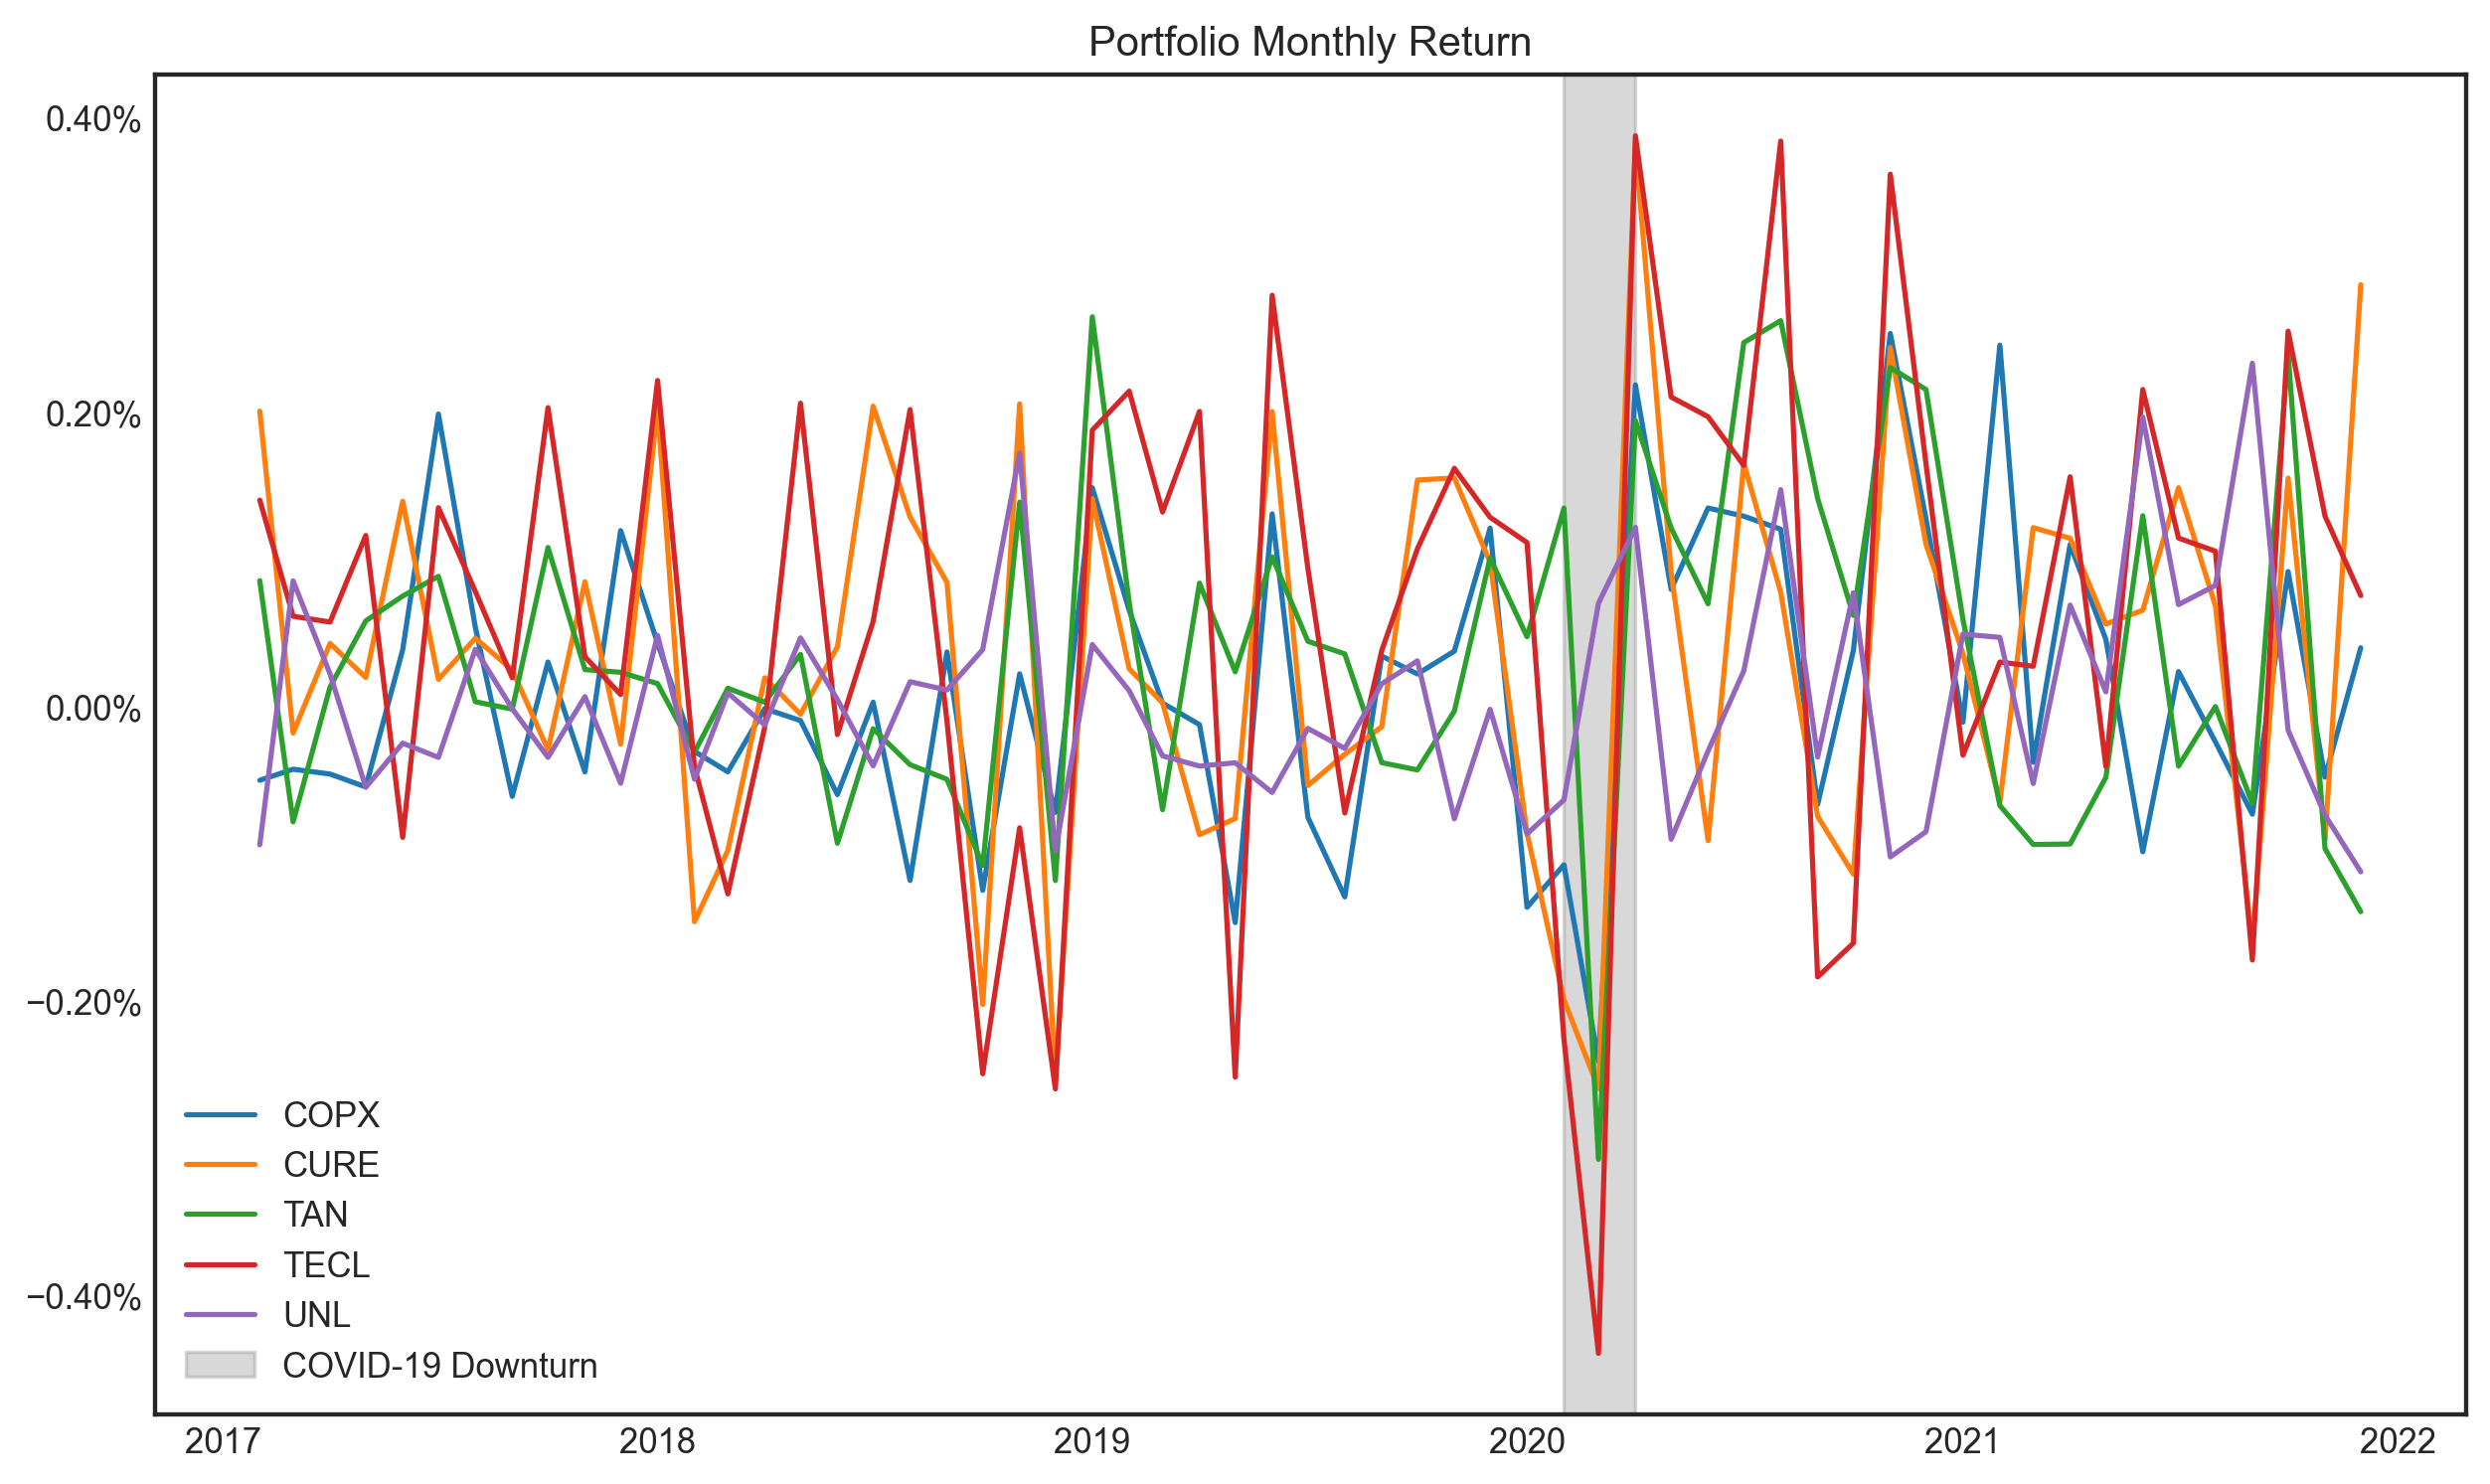

In [15]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(returns, label=returns.columns)
ax.axvspan(
    date2num(datetime(2020, 2, 1)),
    date2num(datetime(2020, 4, 1)),
    label="COVID-19 Downturn",
    color="grey",
    alpha=0.3,
)
ax.legend(loc=3)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_title("Portfolio Monthly Return")
plt.show()


In [16]:
returns_m, returns_n = returns.shape


 #### Table 1: Summary Statistics

In [17]:
# INVESTMENT = int(input("Enter investment amount: "))
INVESTMENT = 10000

table_1 = pd.DataFrame(
    {
        "Arithmetic Mean": returns.mean(),
        "Geometric Mean": (gmean(returns + 1) - 1),
        "Standard Deviation": returns.std(
            ddof=0
        ),  # degrees of freedom=0 for population stats
        "Current Value: $10k": npf.fv(
            rate=(gmean(returns + 1) - 1),
            pmt=0,
            nper=returns_m,
            pv=[-INVESTMENT] * returns_n,
        ),
    }
)
table_1.style.format(proper_format)


 #### Annualized Returns

 And if we decided to look at the annualized returns:

 $$
 APY = (1+r_{\text{month}})^{12} - 1 \\
 \sigma_{\text{yearly}} = \sigma_{\text{month}} \times \sqrt{12}
 $$

In [18]:
annual_geo_from_monthly = lambda r: np.power(np.prod(r + 1), 12 / (len(r))) - 1


In [19]:
annualized = table_1.copy()
annualized["Arithmetic Mean"] = annualized["Arithmetic Mean"] * 12
annualized["Geometric Mean"] = annual_geo_from_monthly(returns)
annualized["Standard Deviation"] = annualized["Standard Deviation"] * (12 ** 0.5)


In [20]:
annualized.style.format(proper_format)


 ### B. Table 2: Covariance Matrix

In [21]:
# All formulas related to variances (i.e., standard deviations, covariance)
# will have `dd=0` for the population standard deviation.
returns.cov(ddof=0)


COPX      CURE       TAN      TECL       UNL
COPX  0.010116  0.007040  0.005539  0.010292 -0.000176
CURE  0.007040  0.017395  0.005646  0.014425  0.000178
TAN   0.005539  0.005646  0.012177  0.009795  0.000035
TECL  0.010292  0.014425  0.009795  0.027510 -0.000412
UNL  -0.000176  0.000178  0.000035 -0.000412  0.005357

 ### C. Table 3: Correlation Matrix

In [22]:
returns.corr()


COPX      CURE       TAN      TECL       UNL
COPX  1.000000  0.530706  0.499076  0.616937 -0.023904
CURE  0.530706  1.000000  0.387951  0.659433  0.018432
TAN   0.499076  0.387951  1.000000  0.535167  0.004344
TECL  0.616937  0.659433  0.535167  1.000000 -0.033947
UNL  -0.023904  0.018432  0.004344 -0.033947  1.000000

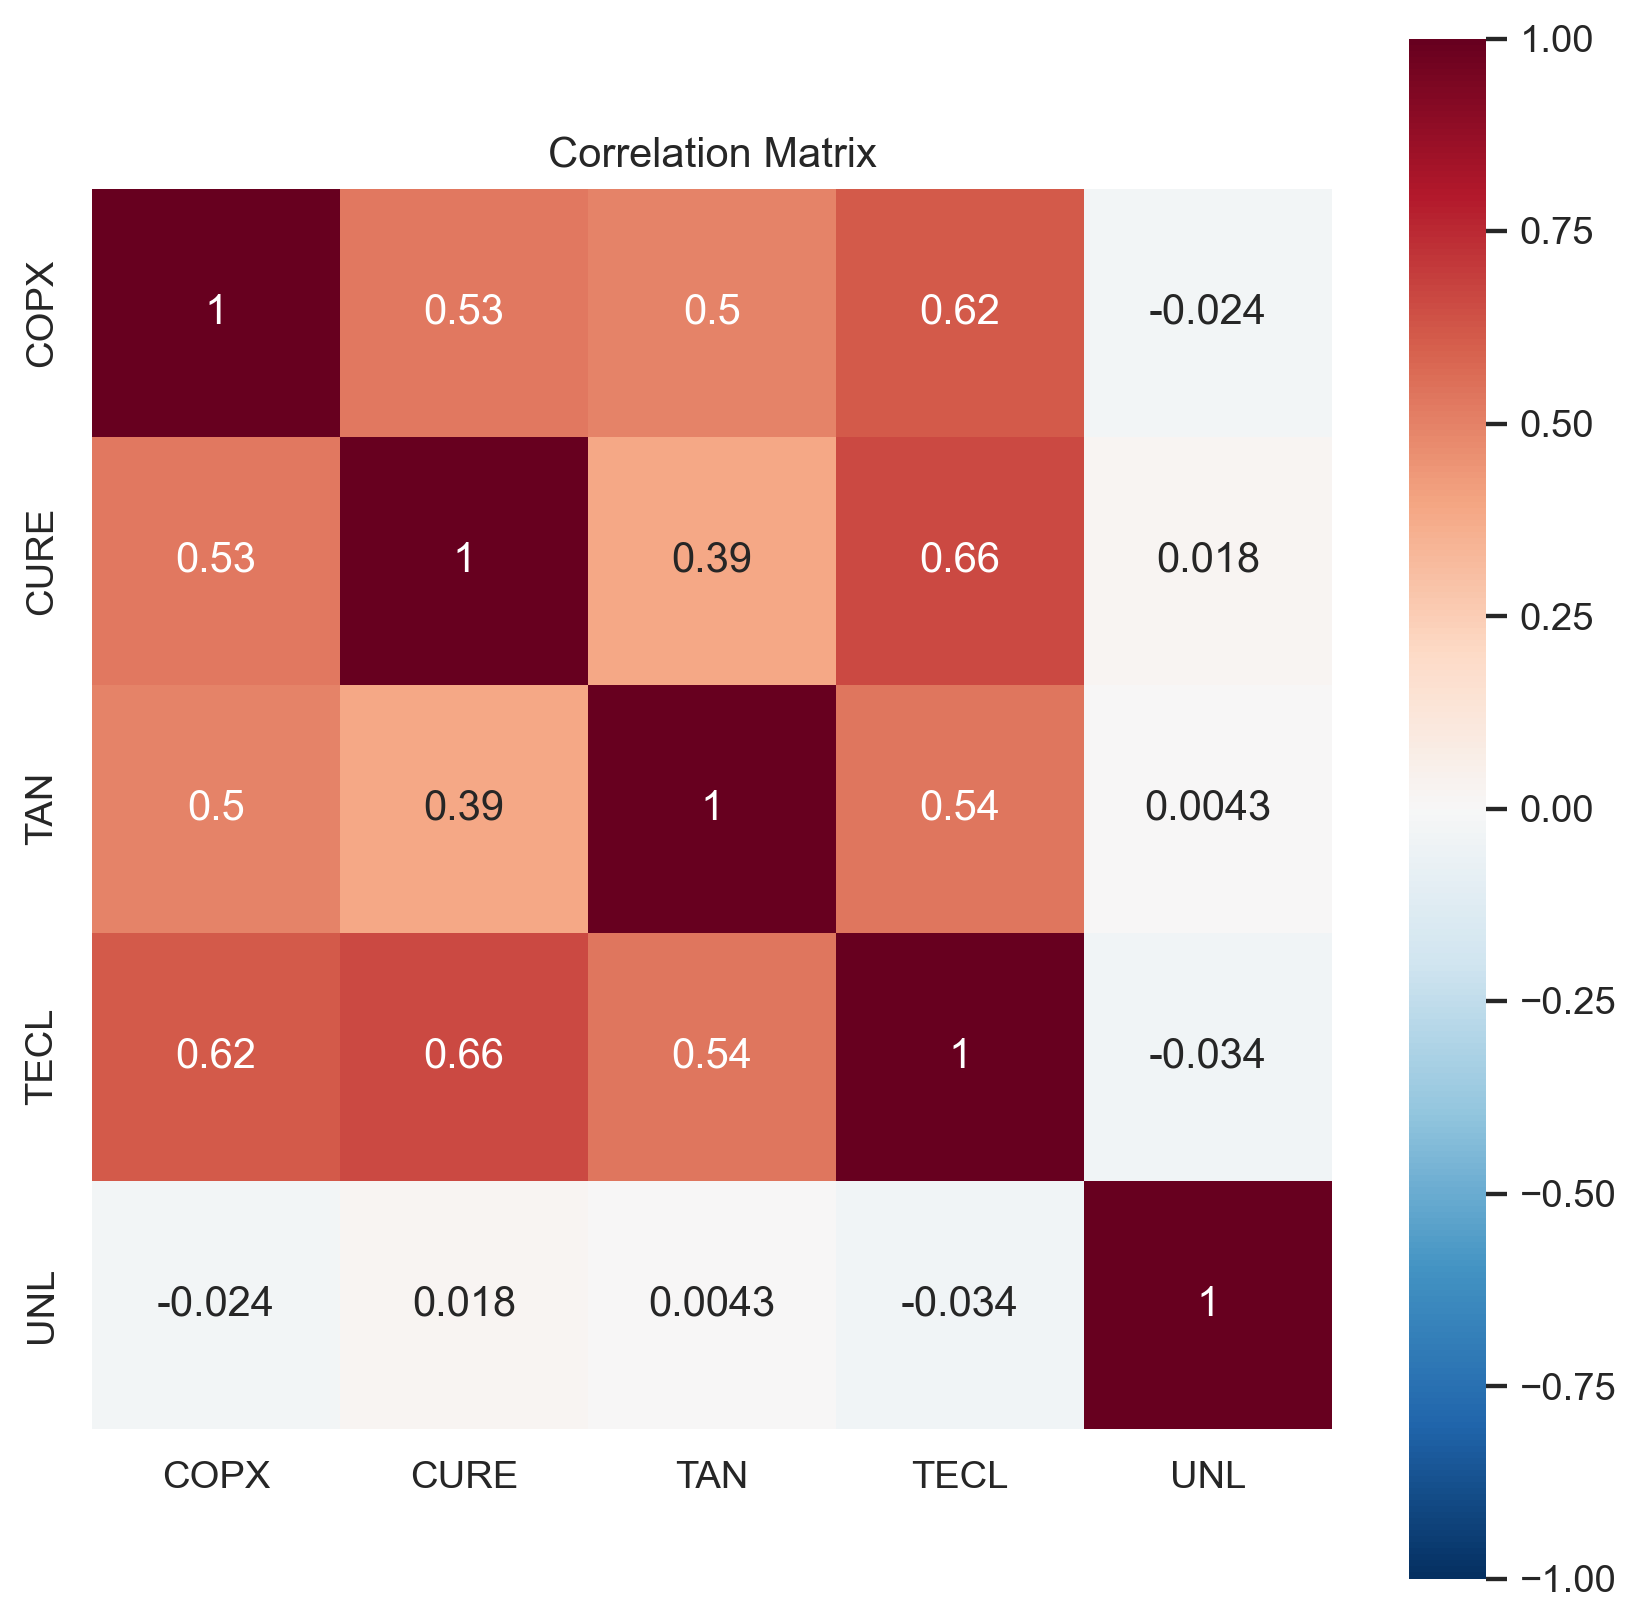

In [23]:
sns.set(rc={"figure.figsize": (n_size * 1.6, n_size * 1.6)})
sns.heatmap(
    returns.corr(),
    annot=True,
    cmap="RdBu_r",
    square=True,
    vmin=-1,
    vmax=1,
).set_title("Correlation Matrix")
plt.show()


In [24]:
sns.set(rc={"figure.figsize": (8, 8)})


 ### D. Prospectus Strategy

 Using each fund’s prospectus or information you find on the web, state in your
 own words the strategy and philosophy of each fund.

 | ETF          | COPX                                                         | CURE                                                         | TAN                                                          | TECL                                                         | UNL                                                          |
 | ------------ | ------------------------------------------------------------ | ------------------------------------------------------------ | ------------------------------------------------------------ | ------------------------------------------------------------ | ------------------------------------------------------------ |
 | **Name**     | Global X Copper Miners ETF                                   | Direxion Daily Healthcare Bull 3X Shares                     | Invesco Solar ETF                                            | Direxion Daily Technology Bull 3x Shares                     | United States 12 Month Natural Gas Fund, LP                  |
 | **About**    | COPX tracks a market-cap-weighted index of global copper mining companies. | CURE provides 3x levered exposure to a market-cap-weighted sub-index of the S&P 500 that tracks the performance of US-listed health care companies. | TAN tracks an index of global solar energy companies selected based on the revenue generated from solar-related business. | TECL provides 3x leveraged exposure to a market-cap weighted index of US large-cap technology companies. | UNL holds the 12 nearest-month NYMEX natural gas futures contracts in equal weights. |
 | **Category** | Basic Materials                                              | Trading--Leveraged Equity                                    | Miscellaneous Sector                                         | Trading--Leveraged Equity                                    | Commodities Focused                                          |
 | **Strategy** | Vanilla                                                      | Vanilla                                                      | Fundamental                                                  | Vanilla                                                      | Laddered                                                     |
 | **Segment**  | Equity: Global Copper Miners                                 | Leveraged Equity: U.S. Health Care                           | Equity: Global Renewable Energy                              | Leveraged Equity: U.S. Information Technology                | Commodities: Energy Natural Gas                              |
 | **Niche**    | ETF                                                          | COPXBroad-based                                              | CURERenewable Energy                                         | TANBroad-based                                               | TECLLaddered                                                 |

 ## Part Two

 ### A. CAPM

 Using Treasury bill rates and the S&P 500 index, run a “CAPM” regression to
 estimate the beta of each fund. Constant maturity 3-month T-bill rates can be
 obtained on the web site of The Federal Reserve Bank of Saint Louis, Missouri
 (“FRED”). These rates are quoted in an annualized format, so adjust them
 according to your needs.

 Beta is defined as:

 $$
 \beta_i = \frac{\sigma_{iM}}{\sigma^{2}_{M}}
 $$

In [25]:
# Note that Python uses zero-indices
# T13W = pdr.DataReader("GS3M", "fred", "02/2017", end)
dates = sorted(returns.index)[0]
start_year = dates.year
start_month = dates.month
start_day = dates.day
T13W = pdr.DataReader("GS3M", "fred", f"{start_month}/{start_year}", end)
Rm = yf.download(
    ["^GSPC", "^DJI"],
    start=datetime(start_year, start_month - 1, start_day),
    end=end,
    interval="1mo",
)["Adj Close"]
# Rm = yf.download(["^GSPC", "^DJI"], start=start, end=end, interval="1mo")["Adj Close"]
Rm = Rm.pct_change().dropna()


[                       0%                       ]

[*********************100%***********************]  2 of 2 completed

 Since Treasury Bill Rates are quoted annually and already in percentage form,
 we will convert this to decimal and monthly return.


 According to the [U.S. Treasury](https://home.treasury.gov/policy-issues/financing-the-government/interest-rate-statistics/interest-rates-frequently-asked-questions),
 the Constant Maturity Rates are _expressed on a simple annualized basis_,
 therefore to convert them to a monthly basis, we will multiply by `12`.

In [26]:
T13W = T13W.div(100).div(12)


 The traditional equation for the Capital Asset Pricing Model
 (CAPM) is as follows:

 $$ R_i = R_f + \beta(R_m -  R_f) $$

 yet we are looking to find the our beta coefficient, which we can find by
 re-arranging the equation into:

 $$ R_i - R_f = \beta(R_m - R_f) $$

 which translates into:

 $$ R_\text{Fund} - R_{\text{TBill 13W}} =  \beta(R_{\text{S&P500}} -
 R_{\text{TBill 13W}}) \\
 $$

 ### B. β

 Repeat part A using this time the Dow Jones Industrial Average instead of the
 S&P 500 index.

In [27]:
# Run the regression for each fund with S^P500 as the benchmark
sp500_ols = [sm.OLS(endog=returns[fund], exog=Rm["^GSPC"]).fit() for fund in funds]


In [28]:
# Run the regression for each fund with the DJIA as the benchmark
djia_ols = [sm.OLS(endog=returns[fund], exog=Rm["^DJI"]).fit() for fund in funds]


In [29]:
for result in sp500_ols:
    display(result.summary())


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   COPX   R-squared (uncentered):                   0.512
Model:                            OLS   Adj. R-squared (uncentered):              0.503
Method:                 Least Squares   F-statistic:                              60.77
Date:                Thu, 03 Nov 2022   Prob (F-statistic):                    1.35e-10
Time:                        22:09:58   Log-Likelihood:                          72.444
No. Observations:                  59   AIC:                                     -142.9
Df Residuals:                      58   BIC:                                     -140.8
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
^GSPC          1.5619      0.200      7.795      0.000       1.161       1.963
==============================================================================
Omnibus:                        3.311   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.191   Jarque-Bera (JB):                2.378
Skew:                           0.380   Prob(JB):                        0.304
Kurtosis:                       3.624   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   CURE   R-squared (uncentered):                   0.731
Model:                            OLS   Adj. R-squared (uncentered):              0.727
Method:                 Least Squares   F-statistic:                              157.8
Date:                Thu, 03 Nov 2022   Prob (F-statistic):                    3.45e-18
Time:                        22:09:58   Log-Likelihood:                          72.391
No. Observations:                  59   AIC:                                     -142.8
Df Residuals:                      58   BIC:                                     -140.7
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
^GSPC          2.5189      0.201     12.561      0.000       2.117       2.920
==============================================================================
Omnibus:                        0.500   Durbin-Watson:                   2.135
Prob(Omnibus):                  0.779   Jarque-Bera (JB):                0.097
Skew:                           0.042   Prob(JB):                        0.953
Kurtosis:                       3.179   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    TAN   R-squared (uncentered):                   0.335
Model:                            OLS   Adj. R-squared (uncentered):              0.324
Method:                 Least Squares   F-statistic:                              29.28
Date:                Thu, 03 Nov 2022   Prob (F-statistic):                    1.25e-06
Time:                        22:09:58   Log-Likelihood:                          55.979
No. Observations:                  59   AIC:                                     -110.0
Df Residuals:                      58   BIC:                                     -107.9
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
^GSPC          1.4331      0.265      5.411      0.000       0.903       1.963
==============================================================================
Omnibus:                        0.241   Durbin-Watson:                   1.274
Prob(Omnibus):                  0.886   Jarque-Bera (JB):                0.195
Skew:                           0.130   Prob(JB):                        0.907
Kurtosis:                       2.893   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   TECL   R-squared (uncentered):                   0.836
Model:                            OLS   Adj. R-squared (uncentered):              0.833
Method:                 Least Squares   F-statistic:                              295.0
Date:                Thu, 03 Nov 2022   Prob (F-statistic):                    2.04e-24
Time:                        22:09:58   Log-Likelihood:                          71.673
No. Observations:                  59   AIC:                                     -141.3
Df Residuals:                      58   BIC:                                     -139.3
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
^GSPC          3.4866      0.203     17.176      0.000       3.080       3.893
==============================================================================
Omnibus:                        1.147   Durbin-Watson:                   2.264
Prob(Omnibus):                  0.563   Jarque-Bera (JB):                0.979
Skew:                           0.058   Prob(JB):                        0.613
Kurtosis:                       2.380   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    UNL   R-squared (uncentered):                   0.000
Model:                            OLS   Adj. R-squared (uncentered):             -0.017
Method:                 Least Squares   F-statistic:                            0.02696
Date:                Thu, 03 Nov 2022   Prob (F-statistic):                       0.870
Time:                        22:09:58   Log-Likelihood:                          70.474
No. Observations:                  59   AIC:                                     -138.9
Df Residuals:                      58   BIC:                                     -136.9
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
^GSPC          0.0340      0.207      0.164      0.870      -0.381       0.449
==============================================================================
Omnibus:                       10.483   Durbin-Watson:                   1.842
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               10.263
Skew:                           0.908   Prob(JB):                      0.00591
Kurtosis:                       3.937   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
# Extract the beta coefficients
sp500_beta = [sp500_ols[fund].params[0] for fund in range(n_size)]
djia_beta = [djia_ols[fund].params[0] for fund in range(n_size)]


In [31]:
betas = pd.DataFrame([sp500_beta, djia_beta], columns=funds, index=["^GSPC", "^DJI"])
display(Markdown("$\\beta$ per Fund and Market"), betas)


$\beta$ per Fund and Market

COPX      CURE       TAN      TECL       UNL
^GSPC  1.561883  2.518928  1.433077  3.486629  0.034017
^DJI   1.532078  2.437485  1.309326  3.188568 -0.073077

In [32]:
riskFree = T13W.mean()[0]
returnSP = Rm["^GSPC"].mean()
returnDJIA = Rm["^DJI"].mean()


 $$E(R_i) = R_f + \beta(R_m -  R_f)$$

In [33]:
E_R = pd.DataFrame()
E_R["^GSPC"] = riskFree + betas.T["^GSPC"] * (returnDJIA - riskFree)
E_R["^DJI"] = riskFree + betas.T["^DJI"] * (returnDJIA - riskFree)


In [34]:
display(Markdown("$E(R)$ Expected Return explained by $R_m$"))
display(
    E_R.sort_index().T.style.format(PERCENT),
    table_1["Arithmetic Mean"].sort_index().to_frame().T.style.format(PERCENT),
)


$E(R)$ Expected Return explained by $R_m$

In [35]:
buy_suggestion = pd.DataFrame()
buy_suggestion["^GSPC"] = (
    E_R["^GSPC"].sort_index() < table_1["Arithmetic Mean"].sort_index()
)
buy_suggestion["^DJI"] = (
    E_R["^DJI"].sort_index() < table_1["Arithmetic Mean"].sort_index()
)
display(
    Markdown(
        "Buy Suggestion: if actual return is larger than expected return $R_i > E(R)$"
    )
)
buy_suggestion.sort_index()


Buy Suggestion: if actual return is larger than expected return $R_i > E(R)$

^GSPC   ^DJI
COPX  False  False
CURE   True   True
TAN    True   True
TECL   True   True
UNL    True   True

 ### C. Table 4

 Show the T-bill rates and the two index levels in tabular form.

In [36]:
table_4 = pd.concat([Rm, T13W], axis=1)
table_4


^DJI     ^GSPC      GS3M
2017-02-01  0.047732  0.037198  0.000442
2017-03-01 -0.007160 -0.000389  0.000625
2017-04-01  0.013419  0.009091  0.000675
2017-05-01  0.003254  0.011576  0.000750
2017-06-01  0.016230  0.004814  0.000833
2017-07-01  0.025363  0.019349  0.000908
2017-08-01  0.002603  0.000546  0.000858
2017-09-01  0.020821  0.019303  0.000875
2017-10-01  0.043390  0.022188  0.000908
2017-11-01  0.038290  0.028083  0.001042
2017-12-01  0.018411  0.009832  0.001117
2018-01-01  0.057857  0.056179  0.001192
2018-02-01 -0.042838 -0.038947  0.001325
2018-03-01 -0.037000 -0.026884  0.001442
2018-04-01  0.002491  0.002719  0.001492
2018-05-01  0.010458  0.021608  0.001583
2018-06-01 -0.005915  0.004842  0.001617
2018-07-01  0.047125  0.036022  0.001658
2018-08-01  0.021626  0.030263  0.001725
2018-09-01  0.019006  0.004294  0.001808
2018-10-01 -0.050742 -0.069403  0.001908
2018-11-01  0.016830  0.017859  0.001975
2018-12-01 -0.086575 -0.091777  0.002008
2019-01-01  0.071684  0.078684  0.002017
2019-02-01  0.036654  0.029729  0.002033
2019-03-01  0.000489  0.017924  0.002042
2019-04-01  0.025618  0.039313  0.002025
2019-05-01 -0.066855 -0.065778  0.002000
2019-06-01  0.071929  0.068930  0.001850
2019-07-01  0.009936  0.013128  0.001792
2019-08-01 -0.017160 -0.018092  0.001658
2019-09-01  0.019450  0.017181  0.001608
2019-10-01  0.004807  0.020432  0.001400
2019-11-01  0.037165  0.034047  0.001308
2019-12-01  0.017362  0.028590  0.001308
2020-01-01 -0.009896 -0.001628  0.001292
2020-02-01 -0.100746 -0.084110  0.001283
2020-03-01 -0.137438 -0.125119  0.000250
2020-04-01  0.110806  0.126844  0.000117
2020-05-01  0.042611  0.045282  0.000108
2020-06-01  0.016931  0.018388  0.000133
2020-07-01  0.023842  0.055101  0.000108
2020-08-01  0.075742  0.070065  0.000083
2020-09-01 -0.022805 -0.039228  0.000092
2020-10-01 -0.046077 -0.027666  0.000083
2020-11-01  0.118372  0.107546  0.000075
2020-12-01  0.032655  0.037121  0.000075
2021-01-01 -0.020383 -0.011137  0.000067
2021-02-01  0.031677  0.026091  0.000033
2021-03-01  0.066247  0.042439  0.000025
2021-04-01  0.027085  0.052425  0.000017
2021-05-01  0.019324  0.005486  0.000017
2021-06-01 -0.000780  0.022214  0.000033
2021-07-01  0.012549  0.022748  0.000042
2021-08-01  0.012173  0.028990  0.000042
2021-09-01 -0.042895 -0.047569  0.000033
2021-10-01  0.058375  0.069144  0.000042
2021-11-01 -0.037294 -0.008334  0.000042
2021-12-01  0.053781  0.043613  0.000050
2022-01-01       NaN       NaN  0.000125

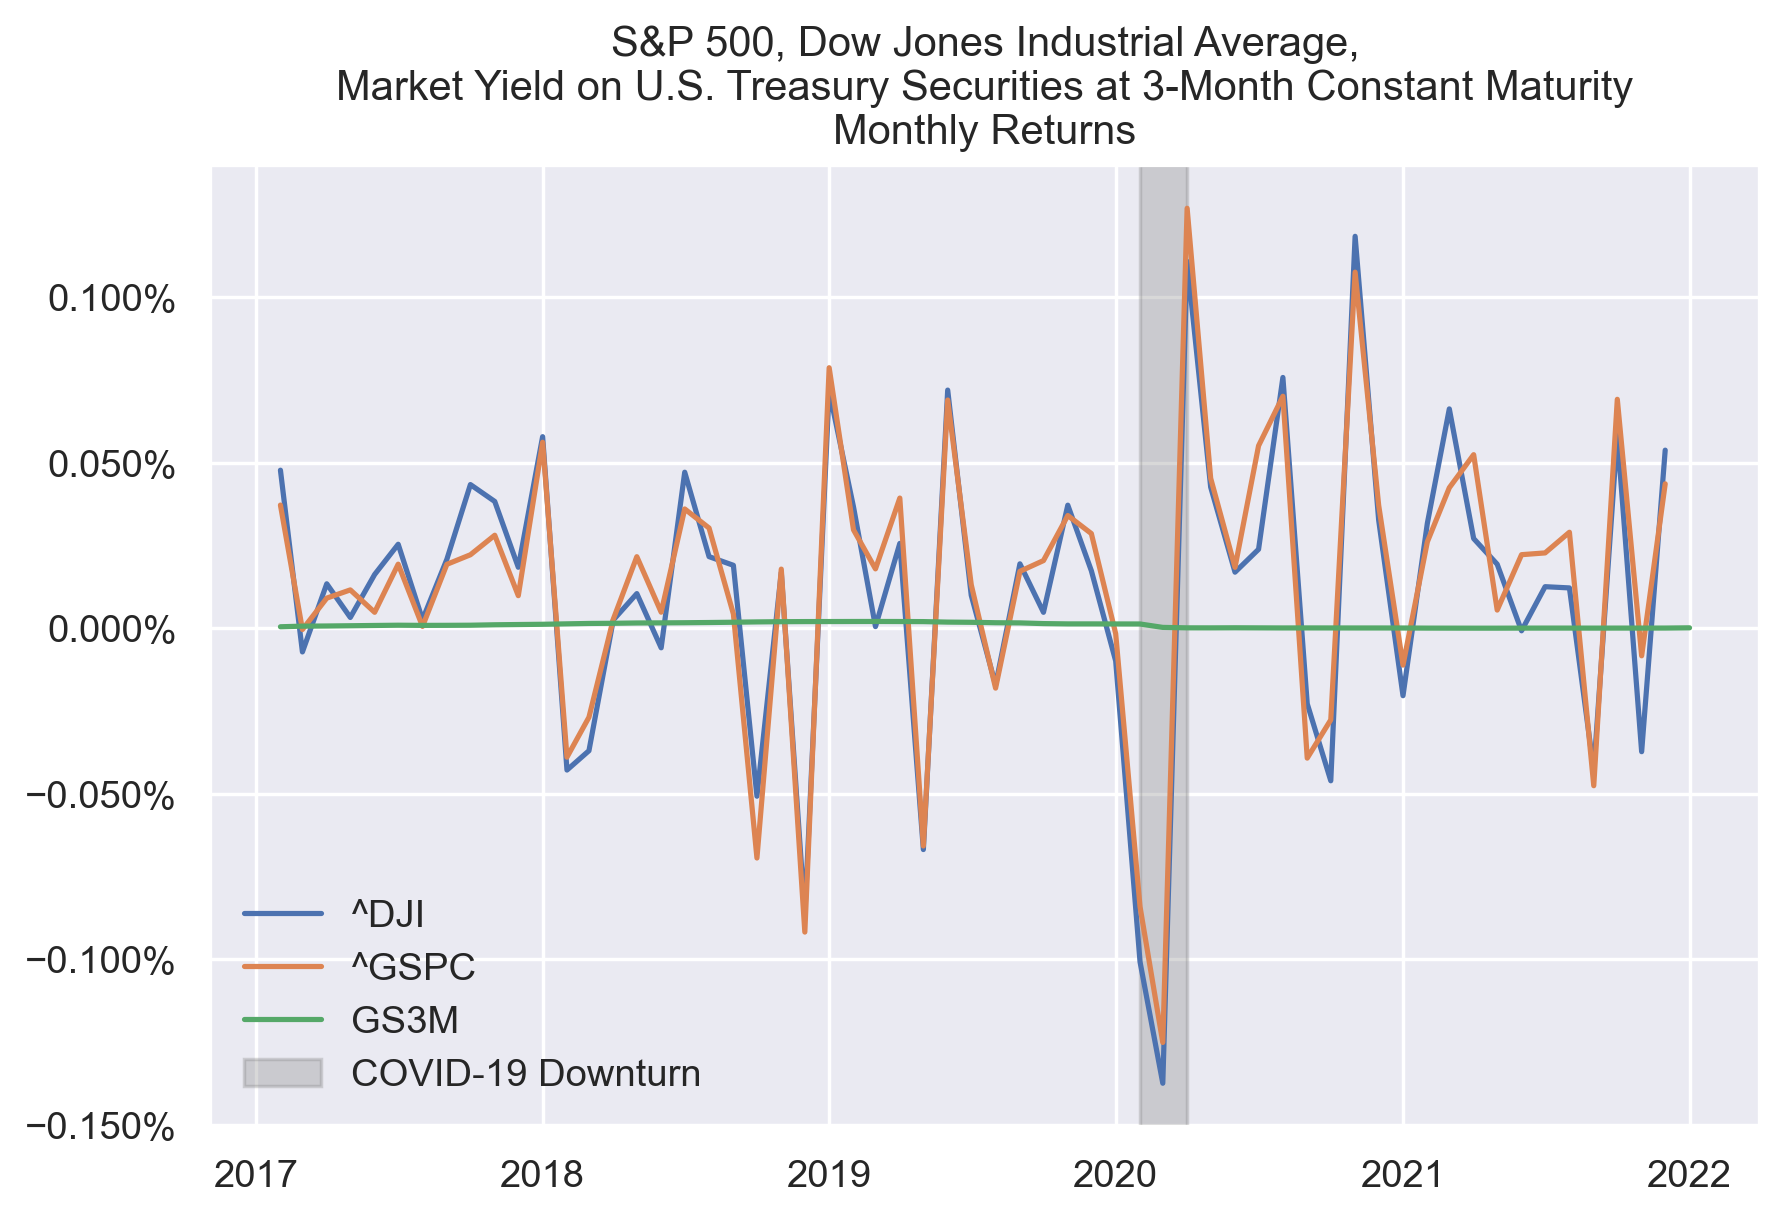

In [37]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(table_4, label=table_4.columns)
ax.axvspan(
    date2num(datetime(2020, 2, 1)),
    date2num(datetime(2020, 4, 1)),
    label="COVID-19 Downturn",
    color="grey",
    alpha=0.3,
)
ax.legend(loc=3)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_title(
    "S&P 500, Dow Jones Industrial Average,"
    "\n"
    "Market Yield on U.S. Treasury Securities at 3-Month Constant Maturity"
    "\n"
    "Monthly Returns"
)
plt.show()


 ### D. Essay: Differences between Dow Jones and S&P 500

In [38]:
display(Markdown("$E(R)$ Expected Return explained by $R_m$"))
display(
    E_R.sort_index().T.style.format(PERCENT),
    table_1["Arithmetic Mean"].sort_index().to_frame().T.style.format(PERCENT),
)


$E(R)$ Expected Return explained by $R_m$

In [39]:
returns_tidy = pd.melt(returns.reset_index(), id_vars="Date").set_index("Date")
returns_tidy = returns_tidy.rename(columns={"variable": "Fund", "value": "Return"})


In [40]:
# This complicated code is to make running possible on Google Colab
try:
    tidy_data = pd.concat([pd.concat([table_4] * n_size), returns_tidy], axis=1)
    tidy_data.to_pickle("data/tidy_huh.pkl")
except:
    get_ipython().system(
        "wget https://raw.githubusercontent.com/danielcs88/project_fin6525/main/data/tidy_huh.pkl"
    )
    with open("tidy_huh.pkl", "rb") as fh:
        tidy_data = pickle.load(fh)


--2022-11-03 22:09:58--  https://raw.githubusercontent.com/danielcs88/project_fin6525/main/data/tidy_huh.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 

200 OK
Length: 13719 (13K) [application/octet-stream]
Saving to: ‘tidy_huh.pkl’

tidy_huh.pkl        100%[===================>]  13.40K  --.-KB/s    in 0s      

2022-11-03 22:09:58 (51.9 MB/s) - ‘tidy_huh.pkl’ saved [13719/13719]



NameError: name 'pickle' is not defined

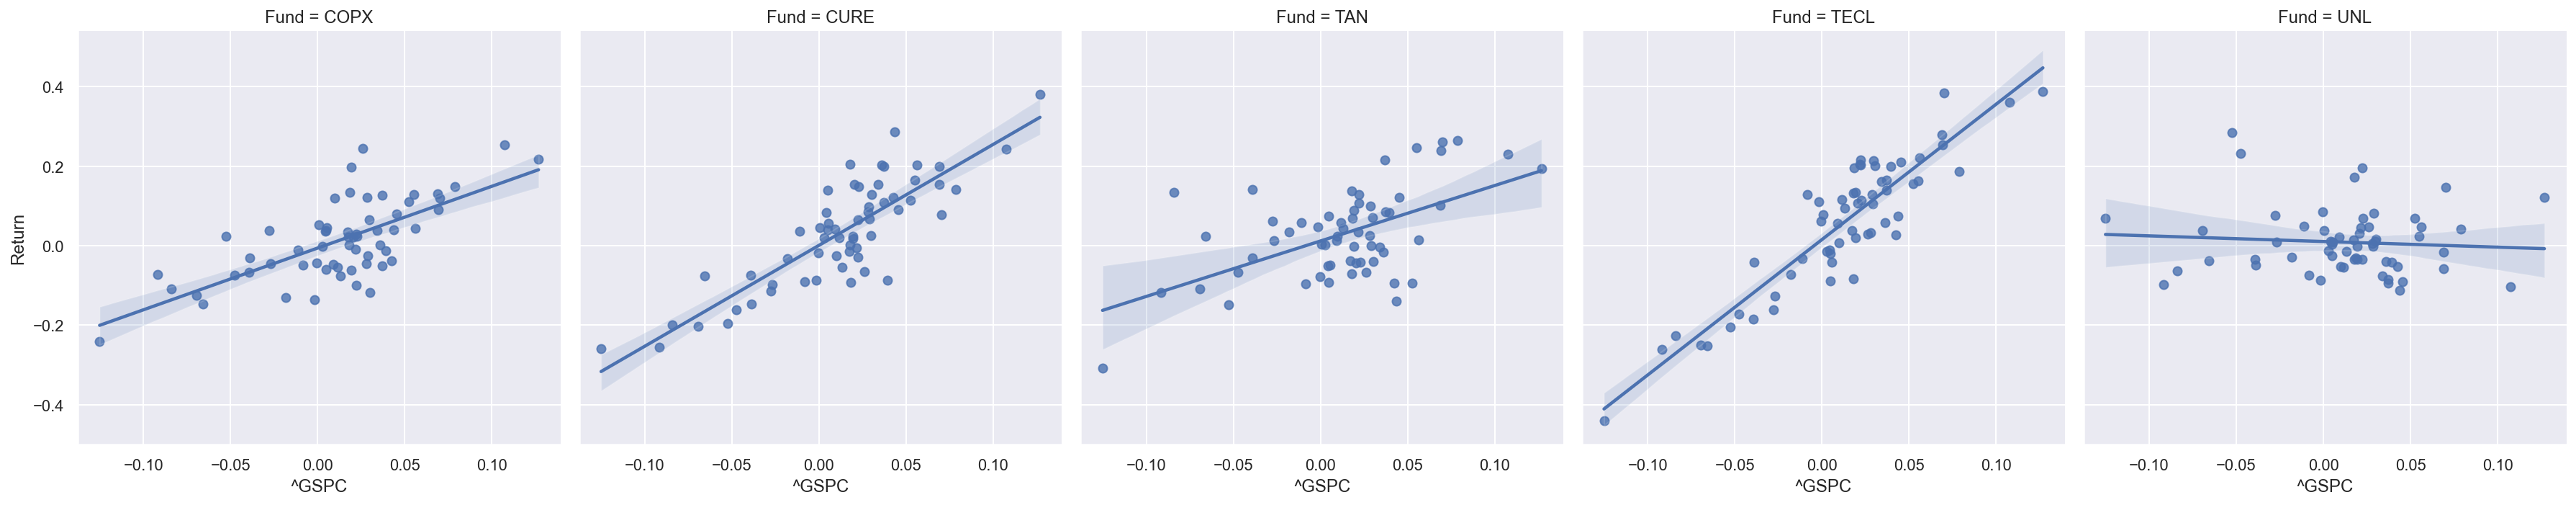

In [42]:
sns.set(rc={"figure.figsize": (6, 30)})
sns.lmplot(x="^GSPC", y="Return", col="Fund", data=tidy_data)
plt.show()


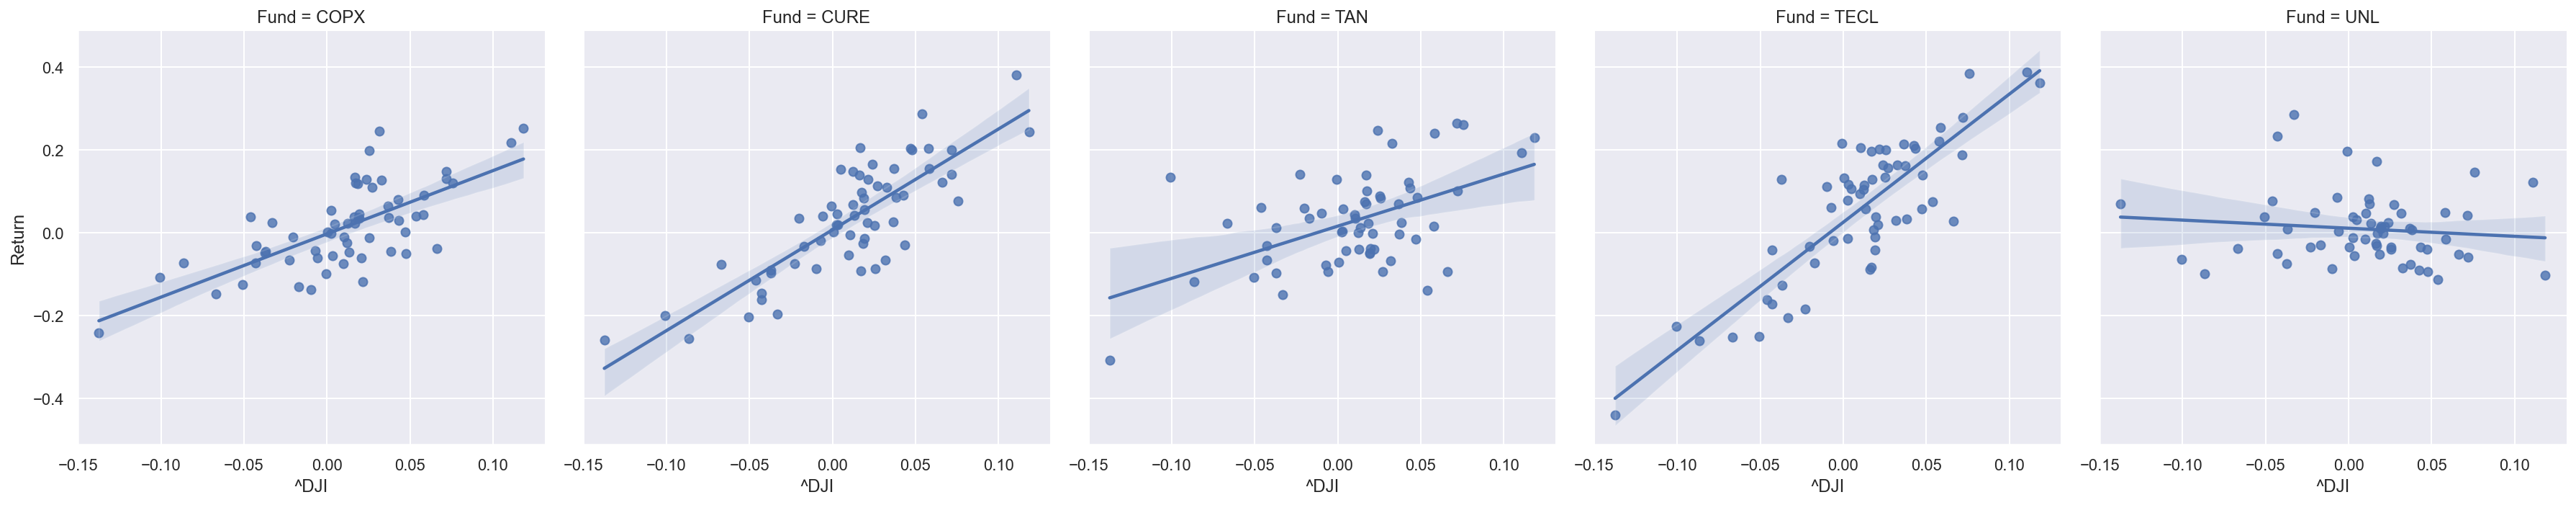

In [43]:
sns.set(rc={"figure.figsize": (6, 30)})
sns.lmplot(x="^DJI", y="Return", col="Fund", data=tidy_data)
plt.show()



 In my particular case, the differences in Expected Return explained by market
 returns by the S&P 500 or the Dow Jones Industrial Average were little.

 The only fund that didn’t perform identically was
 [**UNL**](https://finance.yahoo.com/quote/UNL?p%3DUNL&sa=D&source=editors&ust=1644906676549149&usg=AOvVaw2_AqMFz1d5je1uQkf0XAP0).
 This can be explained by the negative beta values ($\beta_{\text{S\&P}}=-0.08$,
 $\beta_{\text{DJIA}}=-0.14$) from its regression with market returns. While this
 fund had the worst mean individual returns ($R_{\text{UNL}}=10.9\%$ monthly), it
 compensated this by having the lowest risk ($\sigma=28.06\%$) of the portfolio.
 UNL also served as a hedge against all other assets in the portfolio and the
 expected return. Its average correlation with all the assets stands at 3.5% (all
 correlations are negative with all assets).

 However, by running a correlation analysis between the S&P 500 and the Dow
 Jones, it is easy to see why the results are consistently similar; they are 96%
 correlated with each other.

 Another reason, in my opinion why the results are so similar is the ultra-low
 Treasury rates observed throughout the 5-year period. People have little to no
 incentive to purchase Treasury bills.

 Lastly, this period has been one for analysis galore. Supply shocks, demand
 shocks. Oil and energy plunging in the heart of the pandemic and now reaching
 almost $100 a barrel.

 It has been characterized by a very easy monetary policy throughout, it was
 defined by three key events.

 1. Trump Administration monetary policy:

    1. Tax Cuts and Jobs Act (TCJA)

 2. COVID-19 Market Crash
    1. Coronavirus Aid, Relief, and Economic Security Act (CARES Act): $2.2
       trillion economic stimulus
    2. Low Treasury Yields
    3. Federal Reserve
       1. Monetary Easing and Purchase of Treasury Bonds
 3. COVID-19 Recovery
    1. Demand shocks
    2. Supply chain inefficiencies

 People have never had more reasons to trade stocks. All between being
 quarantined in a pandemic with little to do and federal money being put in
 Americans’ pockets, has produced sky-high records in the market.


In [44]:
pd.melt(pd.concat([returns, table_4], axis=1))


variable     value
0       COPX -0.050628
1       COPX -0.043089
2       COPX -0.046366
3       COPX -0.055166
4       COPX  0.038100
..       ...       ...
475     GS3M  0.000033
476     GS3M  0.000042
477     GS3M  0.000042
478     GS3M  0.000050
479     GS3M  0.000125

[480 rows x 2 columns]

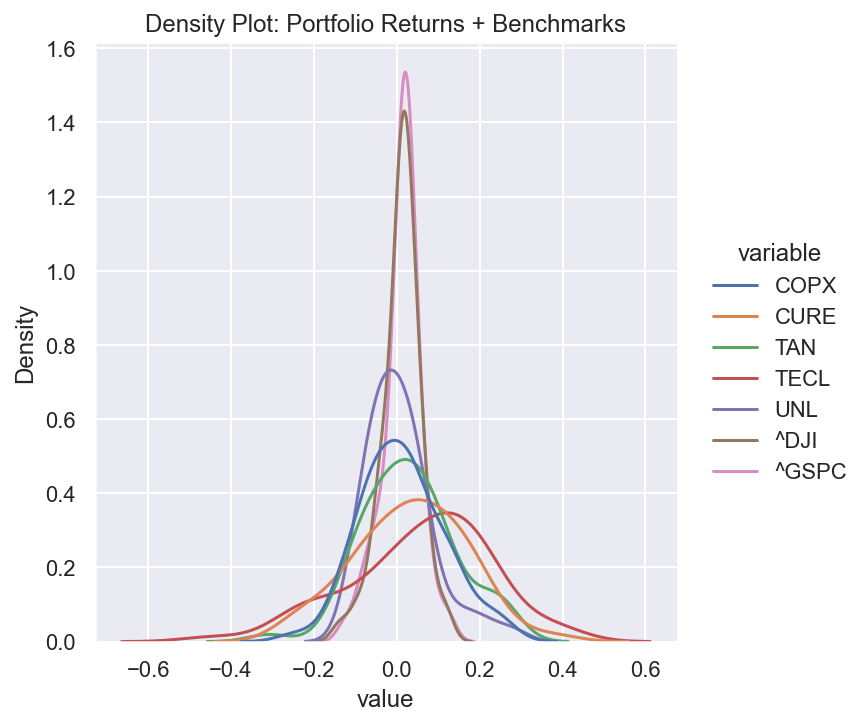

In [45]:
sns.displot(
    (pd.melt(pd.concat([returns, table_4], axis=1)[funds + ["^DJI", "^GSPC"]])),
    x="value",
    hue="variable",
    kind="kde",
).set(title="Density Plot: Portfolio Returns + Benchmarks")
plt.show()


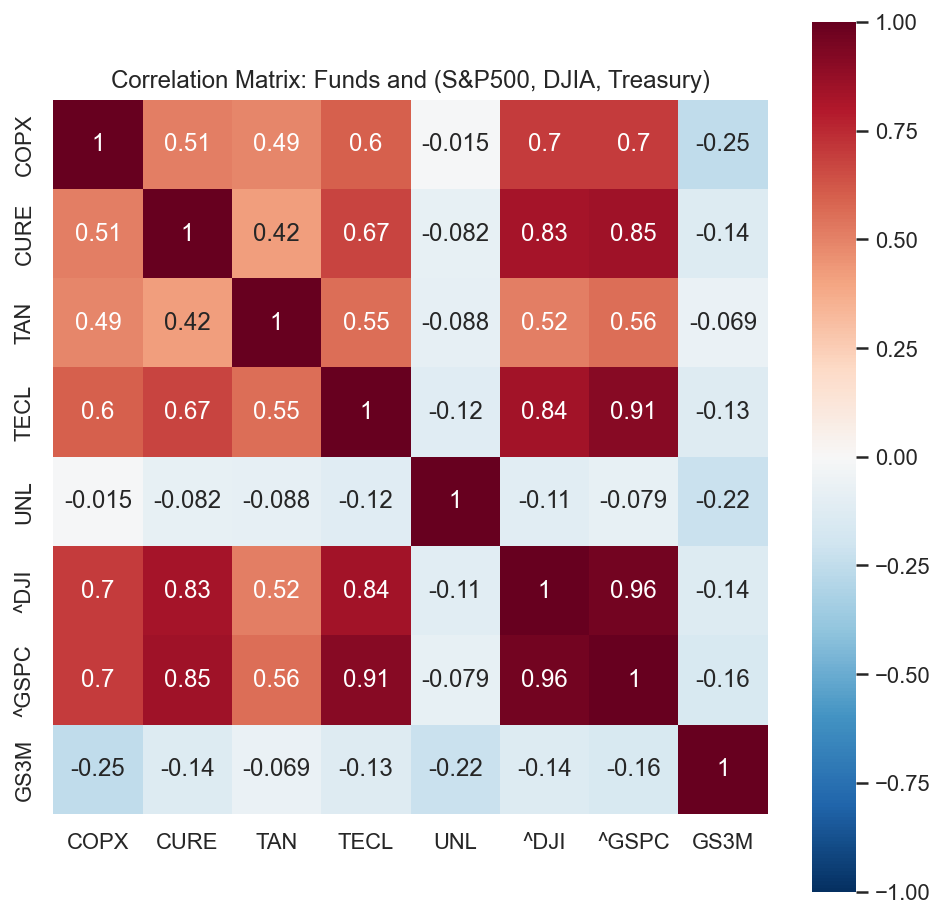

In [46]:
sns.set(rc={"figure.figsize": (n_size * 1.6, n_size * 1.6)})
sns.heatmap(
    pd.concat([returns, table_4], axis=1).corr(),
    annot=True,
    cmap="RdBu_r",
    square=True,
    vmin=-1,
    vmax=1,
).set_title("Correlation Matrix: Funds and (S&P500, DJIA, Treasury)")
plt.show()


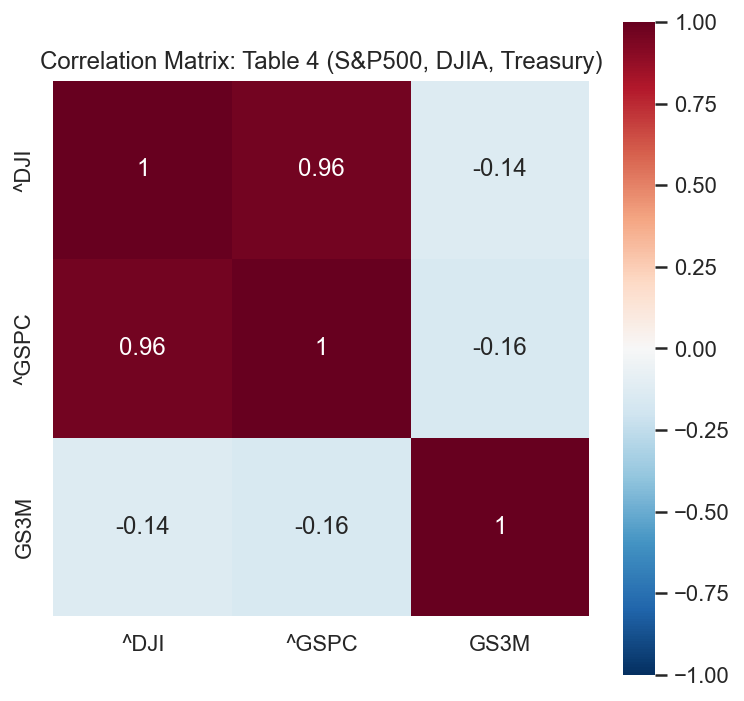

In [47]:
sns.set(rc={"figure.figsize": (6, 6)})
sns.heatmap(
    table_4.corr(),
    annot=True,
    cmap="RdBu_r",
    square=True,
    vmin=-1,
    vmax=1,
).set_title("Correlation Matrix: Table 4 (S&P500, DJIA, Treasury)")
plt.show()


In [48]:
sns.reset_defaults()


 ### E. Runs Test: S&P 500

 $$
 \begin{align}
 Z &= \frac{R-\bar{x}}{\sigma} \\
 \text{where } R &= \text{number of runs;} \\
 \bar{x} &= \frac{2n_1 n_2}{n_1+ n_2} + 1 \\
 \sigma^2 &= \frac{2n_1 n_2 (2n_1 n_2 - n_1 - n_2)}{(n_1+n_2)^2 (n_1 + n_2 - 1)} \\
 n_1, n_2 &= \text{number of observations in each category} \\
 Z &= \text{standard normal variable}
 \end{align}
 $$

In [49]:
sp500 = Rm["^GSPC"]



In [50]:
def num_runs(array) -> int:
    """
    Performs a Runs Test on an array of values, to calculate the number of runs
    and location (indices of runs)

    Parameters
    ----------
    array : np.ndarray
        [description]

    Returns
    -------
    int
        Number of runs in an array.
    """

    # Check where the indices change
    # array[:-1] = all elements except last
    # array[1:] =  all elments except first
    # np.sign will check sign of elements in array
    # - convert to 1 if positive
    # - convert to -1 if negative
    array = np.array(array)
    indices = np.where(np.sign(array[:-1]) != np.sign(array[1:]))[0] + 1
    # return len(indices), indices
    return len(indices)



In [51]:
Z = num_runs(sp500)


In [52]:
np.sign(sp500).value_counts()



 1.0    44
-1.0    16
Name: ^GSPC, dtype: int64

In [53]:
def runs_test(array) -> float:
    R = num_runs(array)
    n1, n2 = list(np.sign(array).value_counts().values)
    x_bar = (2 * n1 * n2) / (n1 + n2) + 1
    sigma_sq = (
        2 * n1 * n2 * (2 * n1 * n2 - n1 - n2) / (((n1 + n2) ** 2) * (n1 + n2 - 1))
    )
    Z = (R - x_bar) / np.sqrt(sigma_sq)
    return Z



In [54]:
Z = runs_test(sp500)
Z


-0.49063938179416305

In [55]:
Z, p = runs.runstest_1samp(Rm["^GSPC"])
runs.runstest_1samp(Rm["^GSPC"])


(0.49131080387234544, 0.6232066396680263)

 #### Runs Test Interpretation

In [56]:
np.sign(sp500).value_counts()


 1.0    44
-1.0    16
Name: ^GSPC, dtype: int64

In [57]:
display(
    Markdown(
        f"""Our Z statistic of **{Z:.3f}** is not close to the standard
normal distribution mean of 0.

We cannot be 95 percent certain that our observed stock prices
did not happen by chance unless we get a Z statistic whose absolute value is
1.96 or greater.

I did all the work above _show my work_, but thankfully Python does have a
faster method for this through `statsmodels`."""
    )
)


Our Z statistic of **0.491** is not close to the standard
normal distribution mean of 0.

We cannot be 95 percent certain that our observed stock prices
did not happen by chance unless we get a Z statistic whose absolute value is
1.96 or greater.

I did all the work above _show my work_, but thankfully Python does have a
faster method for this through `statsmodels`.

In [58]:
display(
    Markdown(
        f"""The z-test statistic turns out to be **$Z={Z:.3f}$** and the
corresponding p-value is **$p={p:.3f}$**. Since this p-value is not less than
α = .05, we fail to reject the null hypothesis. We have sufficient evidence to
say that the data was produced in a random manner."""
    )
)


The z-test statistic turns out to be **$Z=0.491$** and the
corresponding p-value is **$p=0.623$**. Since this p-value is not less than
α = .05, we fail to reject the null hypothesis. We have sufficient evidence to
say that the data was produced in a random manner.

 ## Part Three

 #### A. Table 5

 A. Construct an equally-weighted portfolio of your five funds. Prepare a table
 showing the arithmetic mean return, geometric mean return, and standard
 deviation of return for the five-fund portfolio over the five years [TABLE 5].

 To calculate the standard deviation of the portfolio, we will use the formula
 of the variance of the portfolio and take its square root.

 $$
 \Large
 \begin{gather} \notag
 \begin{aligned}
 \sigma_p &= \sqrt{w' V w} \\
 &= \sqrt{\begin{bmatrix} 0.2 & 0.2 & 0.2 & 0.2 & 0.2 \end{bmatrix} \mathbf{V}
 \begin{bmatrix} 0.2 \\ 0.2 \\ 0.2 \\ 0.2 \\ 0.2 \end{bmatrix}}
 \end{aligned}
 \end{gather}
 $$

In [59]:
# Equal weighted portfolio weights
w = np.array([[1 / n_size] * n_size]).T


In [60]:
table_5 = pd.Series(
    {
        "Arithmetic Mean": returns.mean().dot(w).item(0),
        "Geometric Mean": (gmean(returns + 1) - 1).dot(w).item(0),
        "Standard Deviation": np.sqrt(w.T.dot(returns.cov(ddof=0)).dot(w).item(0)),
    }
).to_frame()
table_5 = table_5.T
table_5.index = ["Equally Weighted Portfolio"]
table_5.style.format(proper_format)


 ### B. Graph 1

 Using Excel, prepare a graph showing the five-year performance of each of your
 funds and the five-fund portfolio. This chart should show the dollar value of
 an initial \\$10,000 investment evolving month-by-month over the five-year
 period.

 #### Static Graph

In [61]:
portfolio_five = pd.DataFrame(
    {"Equally Weigthed Portfolio": INVESTMENT * (1 + returns.mean(axis=1)).cumprod()}
)


In [62]:
sep_funds = (1 + returns).cumprod() * INVESTMENT


In [63]:
investments = pd.concat([portfolio_five, sep_funds], axis=1)


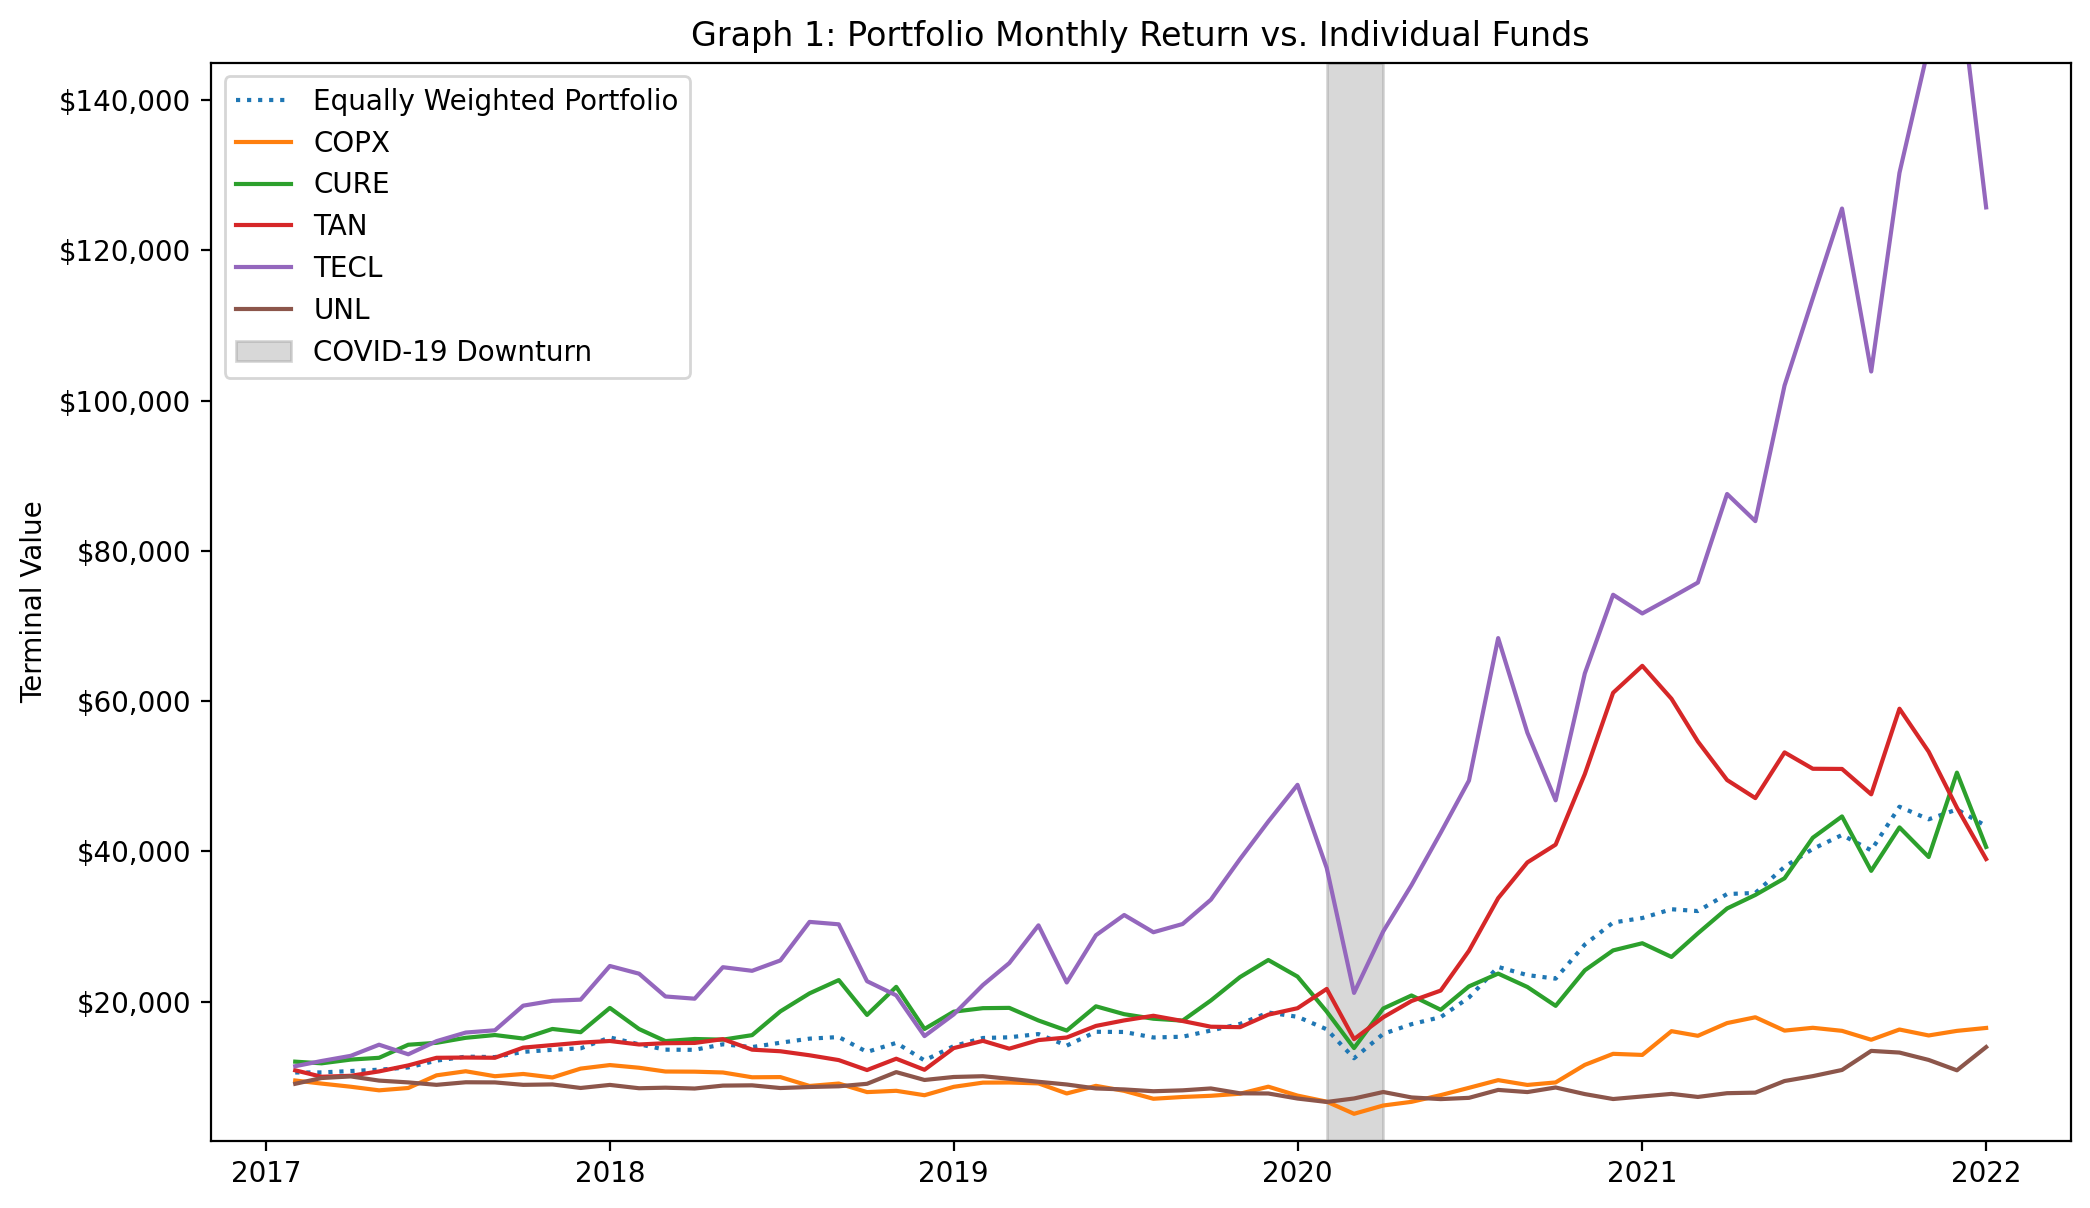

In [64]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(
    investments["Equally Weigthed Portfolio"],
    label="Equally Weighted Portfolio",
    linestyle=":",
)
ax.plot(investments[funds], label=funds)
ax.axvspan(
    date2num(datetime(2020, 2, 1)),
    date2num(datetime(2020, 4, 1)),
    label="COVID-19 Downturn",
    color="grey",
    alpha=0.3,
)
ax.legend()

ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("${x:,.0f}"))
ax.set_ylabel("Terminal Value")
ax.set_title("Graph 1: Portfolio Monthly Return vs. Individual Funds")
ax.set_ylim(1500, 145000)
plt.show()


In [65]:
pandas_bokeh.output_notebook()


Loading BokehJS ...

 #### Dynamic Graph

 If I wanted a more interactive plot, I could use `pandas-bokeh`

In [66]:
investments.plot_bokeh.line(
    title="Graph 1: Individual Funds vs Portfolio",
    disable_scientific_axes="y",
    number_format="‘$0,0.0’",
    ylabel="Terminal Value [$]",
    legend="top_left",
    figsize=(1024, 600),
    panning=False,
    zooming=False,
)
plt.show()


 ## Part Four

 Using the five-year performance statistics of your five funds and the
 five-fund portfolio, determine and show graphically the efficient set using
 the following:

 ### A. Graph 2: Mean Variance Plot

 This is merely a standard deviation / expected return plot showing six points,
 one for each fund and one for the five-fund portfolio. Identify the point that
 shows the best return per unit of risk.

In [67]:
mean_std = [table_1.columns[i] for i in [0, 2]]
mean_var = pd.concat([table_1[mean_std], table_5[mean_std]])
mean_var.style.format(proper_format)


In [68]:
mean_var = mean_var.reset_index()
mean_var.columns = ["Index", "Expected Return", "Standard Deviation"]


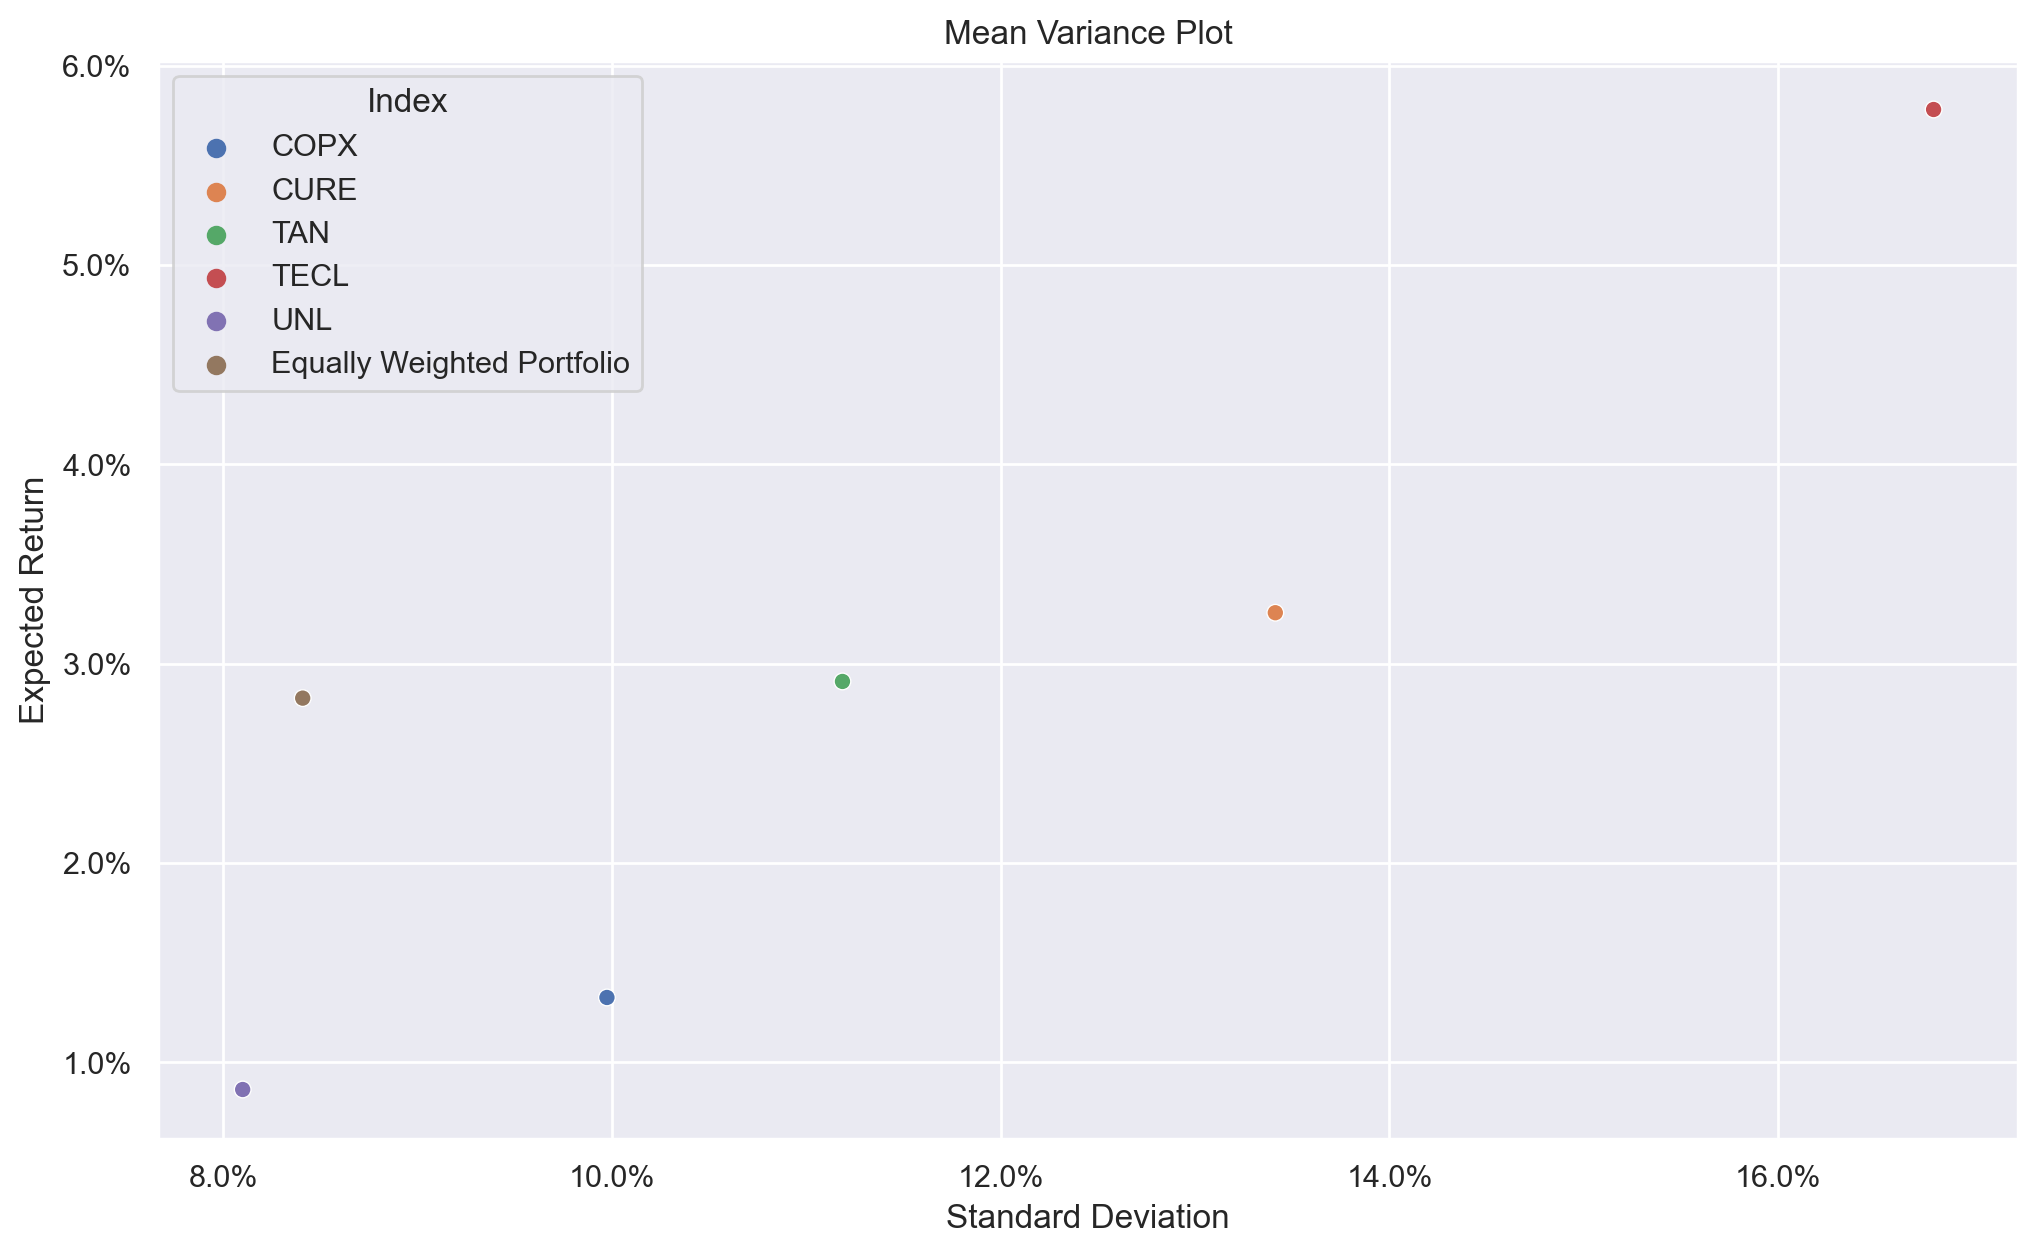

In [69]:
sns.set(rc={"figure.figsize": (12, 7)})
mean_var_plot = sns.scatterplot(
    data=mean_var, x="Standard Deviation", y="Expected Return", hue="Index"
).set(title="Mean Variance Plot")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.show()



 #### Globally Minimum Variance Portfolio

 $$
 \LARGE
 \begin{matrix}
 \notag
 \mu_{*} = \frac{ \mathbf{1}' \mathbf{V}^{-1} \mathbf{\mu} } {\mathbf{1}' \mathbf{V}^{-1} \mathbf{1}  } &
 \sigma_{*}^{2} = (\mathbf{1}' \mathbf{V}^{-1} \mathbf{1})^{-1} &
 w_{*} = \frac{\mathbf{V}^{-1} \mathbf{1}}{\mathbf{1}' \mathbf{V}^{-1} \mathbf{1}}
 \end{matrix}
 $$

In [70]:
mu = table_1["Arithmetic Mean"]
V = returns.cov(ddof=0)
one = np.ones((n_size, 1))


In [71]:
w_star = pd.DataFrame(
    np.linalg.inv(V).dot(one) / (one.T.dot(np.linalg.inv(V))).dot(one),
    index=returns.columns,
    columns=["w*"],
)
w_star


w*
COPX  0.216967
CURE  0.111532
TAN   0.202804
TECL -0.064152
UNL   0.532849

In [72]:
mu_star = (
    one.T.dot(np.linalg.inv(V)).dot(mu) / (one.T.dot(np.linalg.inv(V))).dot(one).item(0)
).item(0)
print("μ* =", f"{mu_star:,.3%} monthly")
print("μ* =", f"{((1+mu_star)**12)-1:,.3%} annually")


μ* = 1.331% monthly
μ* = 17.193% annually


In [73]:
var_star = np.linalg.inv((one.T.dot(np.linalg.inv(V))).dot(one)).item(0)
print("σ²* =", f"{var_star:.4f}")
print("σ* =", f"{np.sqrt(var_star):,.4%}")


σ²* = 0.0033
σ* = 5.7558%


 As reference let's add these points to our Mean Variance Plot

In [74]:
mean_var = mean_var.append(
    pd.Series(
        {
            "Index": "Global Minimum Variance Portfolio",
            "Expected Return": mu_star,
            "Standard Deviation": np.sqrt(var_star),
        }
    ),
    ignore_index=True,
)


/var/folders/b2/v45lt7p54jnb9jn_ckzcv0jm0000gn/T/ipykernel_12666/3732389464.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_var = mean_var.append(


In [75]:
with pd.option_context("display.float_format", PERCENT.format):
    display(mean_var)


Index  Expected Return  Standard Deviation
0                               COPX           1.326%              9.975%
1                               CURE           3.256%             13.413%
2                                TAN           2.911%             11.186%
3                               TECL           5.780%             16.799%
4                                UNL           0.864%              8.101%
5         Equally Weighted Portfolio           2.827%              8.410%
6  Global Minimum Variance Portfolio           1.331%              5.756%

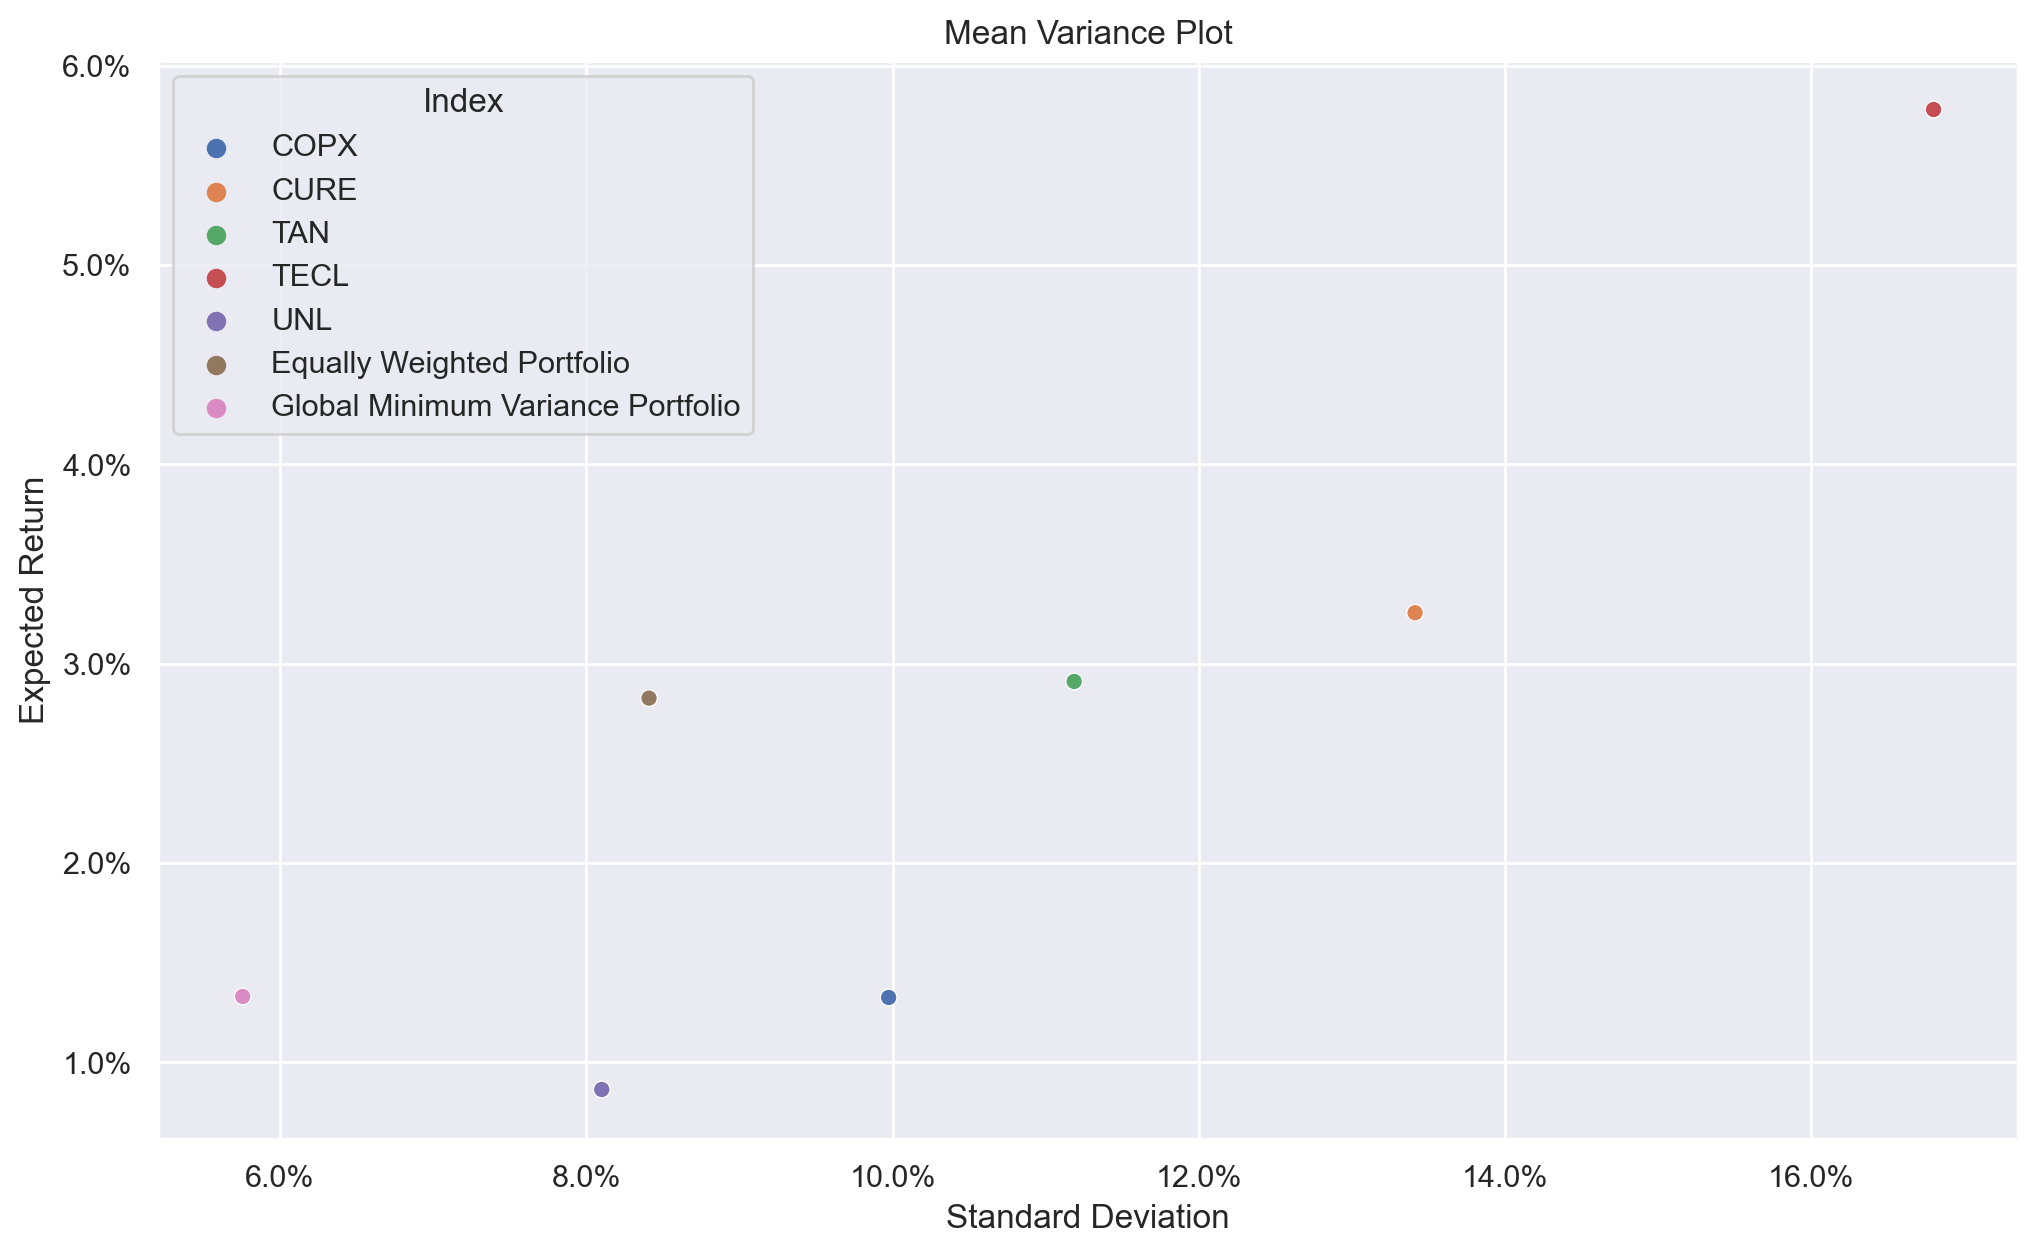

In [76]:
mean_var_plot = sns.scatterplot(
    data=mean_var, x="Standard Deviation", y="Expected Return", hue="Index"
).set(title="Mean Variance Plot")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.show()



 ### B. Graph 3: Mean-Variance Frontier

 Using the matrix Excel-based techniques learned in class, use the five funds
 and their statistics to derive the mean-variance frontier. Draw a plot showing
 the frontier as well as the 5 mean-variance points of the five individual
 funds.

 **Efficient Portfolio Frontier**
 $$
 \Large
 \sigma^{2}_{p} = \begin{bmatrix}E(R_p) \\ 1 \end{bmatrix}'  \left(\begin{bmatrix}\mu_i & 1 \\ \vdots & \vdots \\ \mu_n & 1\end{bmatrix}' \mathbf{V}^{-1} \begin{bmatrix}\mu_i & 1 \\ \vdots & \vdots \\ \mu_n & 1\end{bmatrix}\right)^{-1} \begin{bmatrix}E(R_p) \\ 1\end{bmatrix}
 $$

 **Optimal Weights**
 $$
 \Large
 \underbrace{w}_{n \times 1} = \underbrace{\underbrace{\underbrace{\mathbf{V}^{-1}}_{n \times n} \cdot \underbrace{\begin{bmatrix}\mu_i & 1 \\ \vdots & \vdots \\ \mu_n & 1\end{bmatrix}}_{n \times 2} \cdot }_{n \times 2}\underbrace{\left(\underbrace{\begin{bmatrix}\mu_i & 1 \\ \vdots & \vdots \\ \mu_n & 1\end{bmatrix}'}_{2 \times n} \cdot \underbrace{\mathbf{V}^{-1}}_{n \times n} \cdot \underbrace{\begin{bmatrix}\mu_i & 1 \\ \vdots & \vdots \\ \mu_n & 1\end{bmatrix}}_{n \times 2}\right)^{-1}}_{2 \times 2} \cdot \underbrace{\begin{bmatrix}E(R_p) \\ 1\end{bmatrix}}_{2 \times 1}}_{n \times 1}
 $$

 I will convert all returns into annual returns to better interpret and
 visualize results:

In [77]:
def mean_variance_frontier(
    required_return: float, timeframe: str = "Y", df: pd.DataFrame = returns
) -> List:
    """
    Helper function to calculate the mean-variance frontier.

    Parameters
    ----------
    required_return : float
        Required rate of return.
    timeframe : str, optional
        Annual timeframe for returns, if different parameter will return monthly
        results, by default "Y"
    df : pd.DataFrame, optional
        DataFrame to pass to analyze, by default returns

    Returns
    -------
    List
        Returns a list of the following elements:
        [Expected Return, Standard Deviation, W1, W2, W3, W4, W5]
    """

    if timeframe == "Y":
        mu = ((1 + returns.mean()) ** 12) - 1
        V_inv = np.linalg.inv(df.cov(ddof=0) * 12)
    else:
        V_inv = np.linalg.inv(df.cov(ddof=0))
        mu = df.mean()

    ones = np.ones(len(df.columns))
    mu_one = np.column_stack((mu, ones))

    factor_1 = V_inv.dot(mu_one)
    factor_2 = np.linalg.inv((mu_one.T.dot(V_inv)).dot(mu_one))
    required_vector = np.array([[required_return], [1]])

    w_func = np.squeeze((factor_1.dot(factor_2)).dot(required_vector))
    expected_return = np.squeeze(w_func.T.dot(mu)).item(0)
    sigma = np.squeeze(
        np.sqrt((required_vector.T.dot(factor_2)).dot(required_vector))
    ).item(0)

    # print(sigma ** 2)

    mean_var_df = pd.DataFrame((expected_return, sigma)).T
    mean_var_df.columns = ["E(Rp)", "SD(p)"]

    return functools.reduce(operator.iconcat, [[expected_return, sigma], w], [])



In [78]:
def frontier_df(required_return: float) -> pd.DataFrame:
    """
    Helper function to generate a dataframe of the mean-variance frontier.

    Parameters
    ----------
    required_return : float
        Required rate of return.

    Returns
    -------
    pd.DataFrame
        Mean Variance Frontier in DataFrame format.
    """
    frontiers = [
        mean_variance_frontier(i) for i in np.linspace(0, required_return, 500)
    ]
    frontier_pd = pd.DataFrame(frontiers)
    frontier_pd.columns = functools.reduce(
        operator.iconcat, [["E(Rp)", "SD(P)"], returns.columns], []
    )

    return frontier_pd



In [79]:
frontier = frontier_df(0.01)

with pd.option_context("display.float_format", PERCENT.format):
    display(frontier)



E(Rp)   SD(P)   COPX   CURE    TAN   TECL    UNL
0   -0.000% 22.244%  [0.2]  [0.2]  [0.2]  [0.2]  [0.2]
1    0.002% 22.243%  [0.2]  [0.2]  [0.2]  [0.2]  [0.2]
2    0.004% 22.243%  [0.2]  [0.2]  [0.2]  [0.2]  [0.2]
3    0.006% 22.242%  [0.2]  [0.2]  [0.2]  [0.2]  [0.2]
4    0.008% 22.242%  [0.2]  [0.2]  [0.2]  [0.2]  [0.2]
..      ...     ...    ...    ...    ...    ...    ...
495  0.992% 21.994%  [0.2]  [0.2]  [0.2]  [0.2]  [0.2]
496  0.994% 21.993%  [0.2]  [0.2]  [0.2]  [0.2]  [0.2]
497  0.996% 21.993%  [0.2]  [0.2]  [0.2]  [0.2]  [0.2]
498  0.998% 21.992%  [0.2]  [0.2]  [0.2]  [0.2]  [0.2]
499  1.000% 21.992%  [0.2]  [0.2]  [0.2]  [0.2]  [0.2]

[500 rows x 7 columns]

 Now to annualize the results:

In [80]:
def monthly_to_annual(df: pd.DataFrame = mean_var) -> pd.DataFrame:
    """
    Helper function to convert monthly returns to annual returns.

    Parameters
    ----------
    df : pd.DataFrame, optional
        _description_, by default mean_var

    Returns
    -------
    pd.DataFrame
        Annualized returns in DataFrame format.
    """

    df["Expected Return"] = ((df["Expected Return"] + 1) ** 12) - 1
    df["Standard Deviation"] = df["Standard Deviation"] * (12 ** 0.5)

    return df



In [81]:
annual_mean_var = monthly_to_annual()


In [82]:
with pd.option_context("display.float_format", PERCENT.format):
    display(annual_mean_var)


Index  Expected Return  Standard Deviation
0                               COPX          17.123%             34.553%
1                               CURE          46.883%             46.464%
2                                TAN          41.105%             38.750%
3                               TECL          96.264%             58.195%
4                                UNL          10.878%             28.062%
5         Equally Weighted Portfolio          39.735%             29.132%
6  Global Minimum Variance Portfolio          17.193%             19.939%

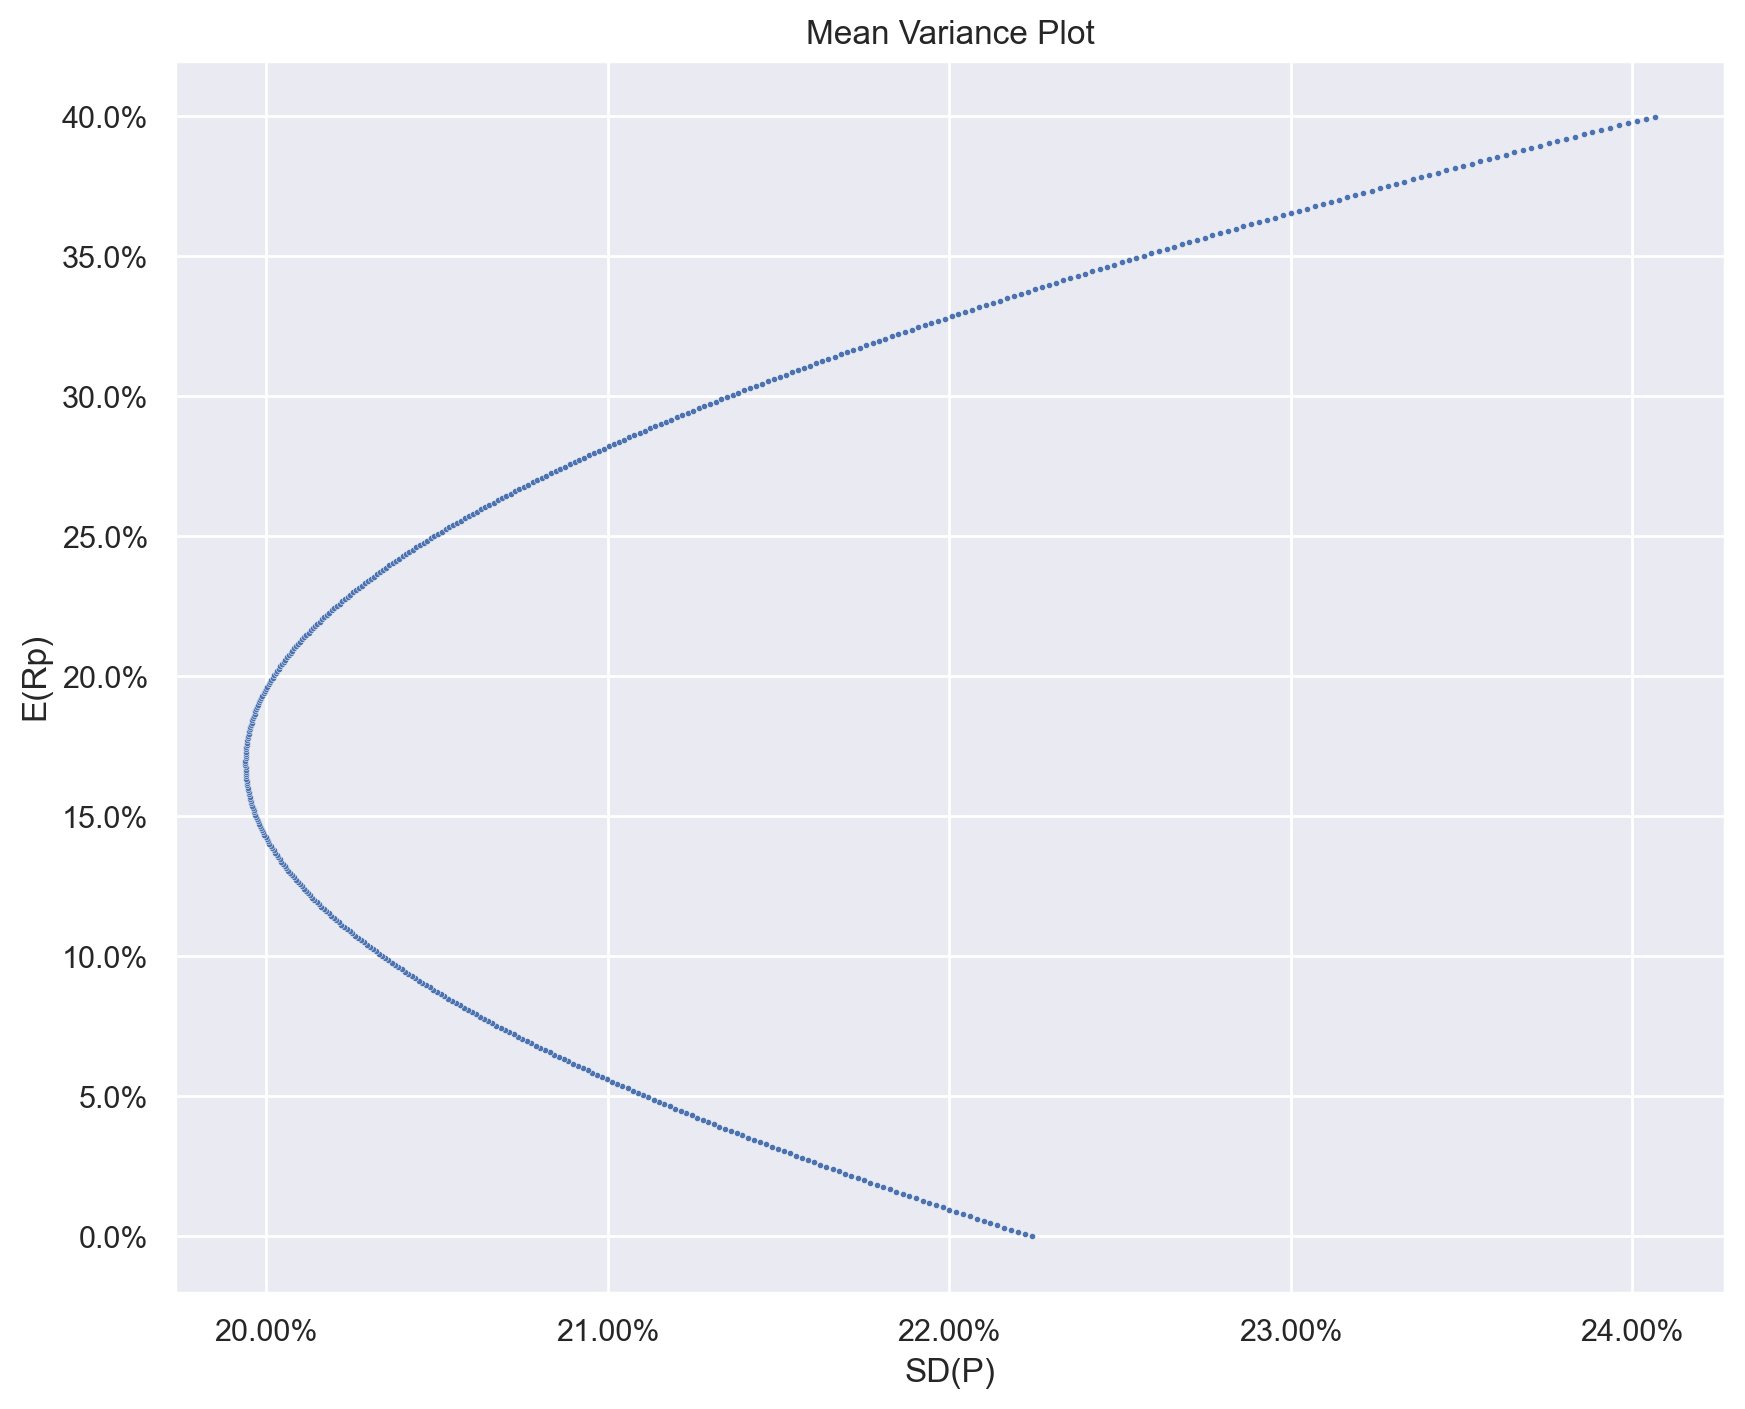

In [83]:
sns.set(rc={"figure.figsize": (10, 8)})
mean_var_plot = sns.scatterplot(data=frontier_df(0.4), x="SD(P)", y="E(Rp)", s=5).set(
    title="Mean Variance Plot"
)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.show()


 Since the annual return for one of my funds is nearly 100%, the shape of this
 frontier compared to each fund looks strange.

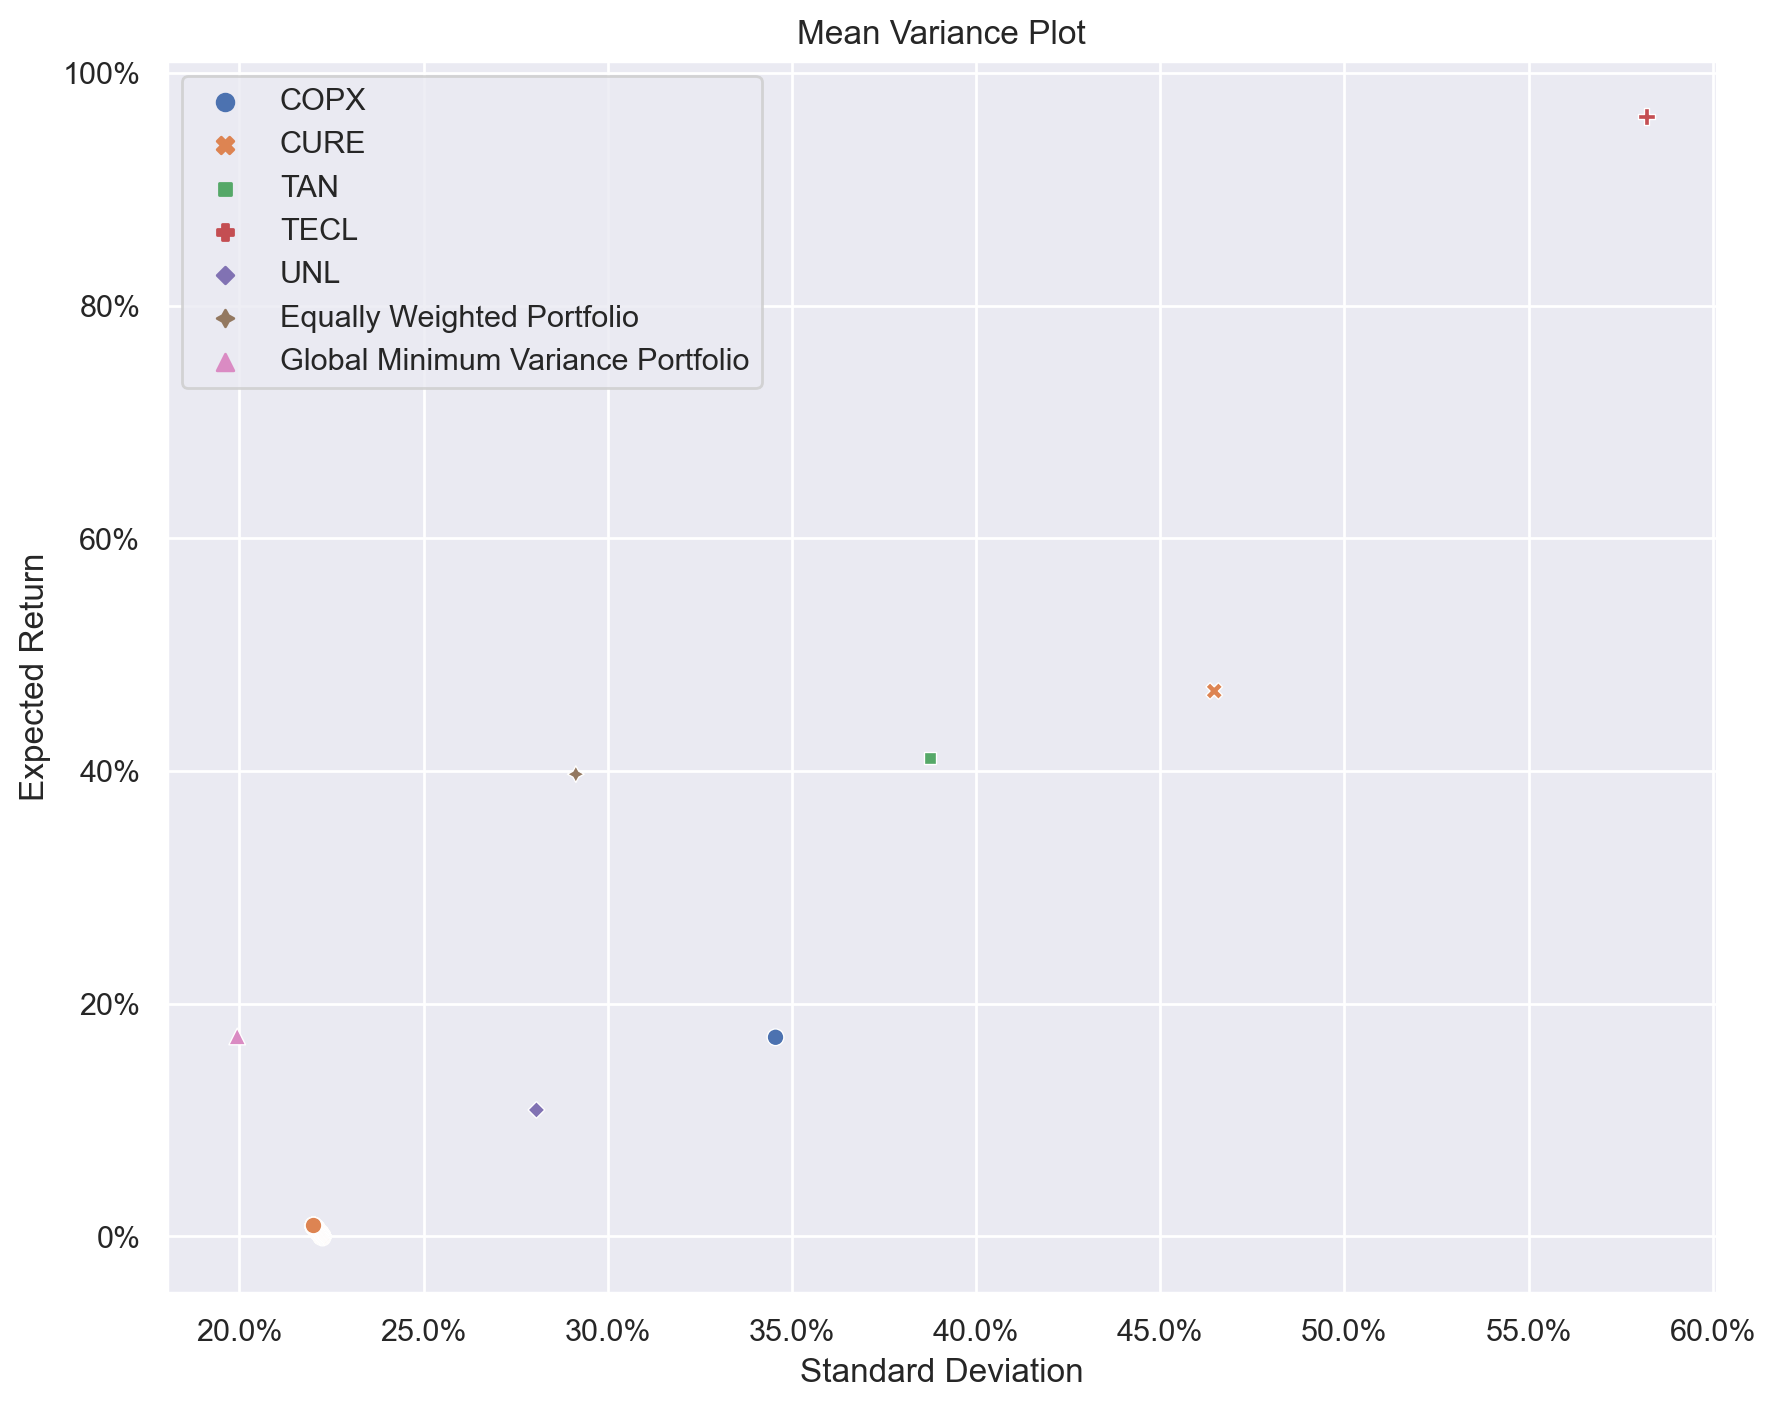

In [84]:
sns.scatterplot(
    data=annual_mean_var,
    x="Standard Deviation",
    y="Expected Return",
    hue="Index",
    style="Index",
).set(title="Mean Variance Plot")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1))

mean_var_plot = sns.scatterplot(data=frontier, x="SD(P)", y="E(Rp)").set(
    title="Mean Variance Plot"
)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.show()


 #### Random Portfolios

 We can also generate random portfolios by the following:

In [85]:
port_returns = []
port_sd = []
port_w = []

num_assets = n_size
num_portfolios = int(input("How many random portfolios would you like to generate? "))
# num_portfolios = 25000

for _ in range(num_portfolios):
    # Random generation of weights
    weights = np.random.random(num_assets)
    # Normalization of weights
    weights /= np.sum(weights)
    port_w.append(weights)

    port_returns.append(np.dot(weights, ((1 + returns.mean()) ** 12) - 1))
    port_var = (
        12 * returns.cov(ddof=0).mul(weights, axis=0).mul(weights, axis=1).sum().sum()
    )
    sd_port = np.sqrt(port_var)
    port_sd.append(sd_port)


In [86]:
data = {"Expected Return": port_returns, "Standard Deviation": port_sd}

for counter, symbol in enumerate(returns.columns.tolist()):
    data[symbol] = [w[counter] for w in port_w]


In [87]:
randomPortfolios = pd.DataFrame(data)


In [88]:
randomPortfolios.head()


Expected Return  Standard Deviation      COPX      CURE       TAN  \
0         0.504449            0.314567  0.017585  0.261796  0.215569   
1         0.324839            0.256578  0.300058  0.230187  0.068800   
2         0.456896            0.348784  0.188137  0.421262  0.196718   
3         0.345143            0.309361  0.329891  0.413990  0.103221   
4         0.329976            0.274479  0.295292  0.302140  0.160193   

       TECL       UNL  
0  0.275398  0.229651  
1  0.109673  0.291282  
2  0.146663  0.047220  
3  0.041580  0.111318  
4  0.053343  0.189032

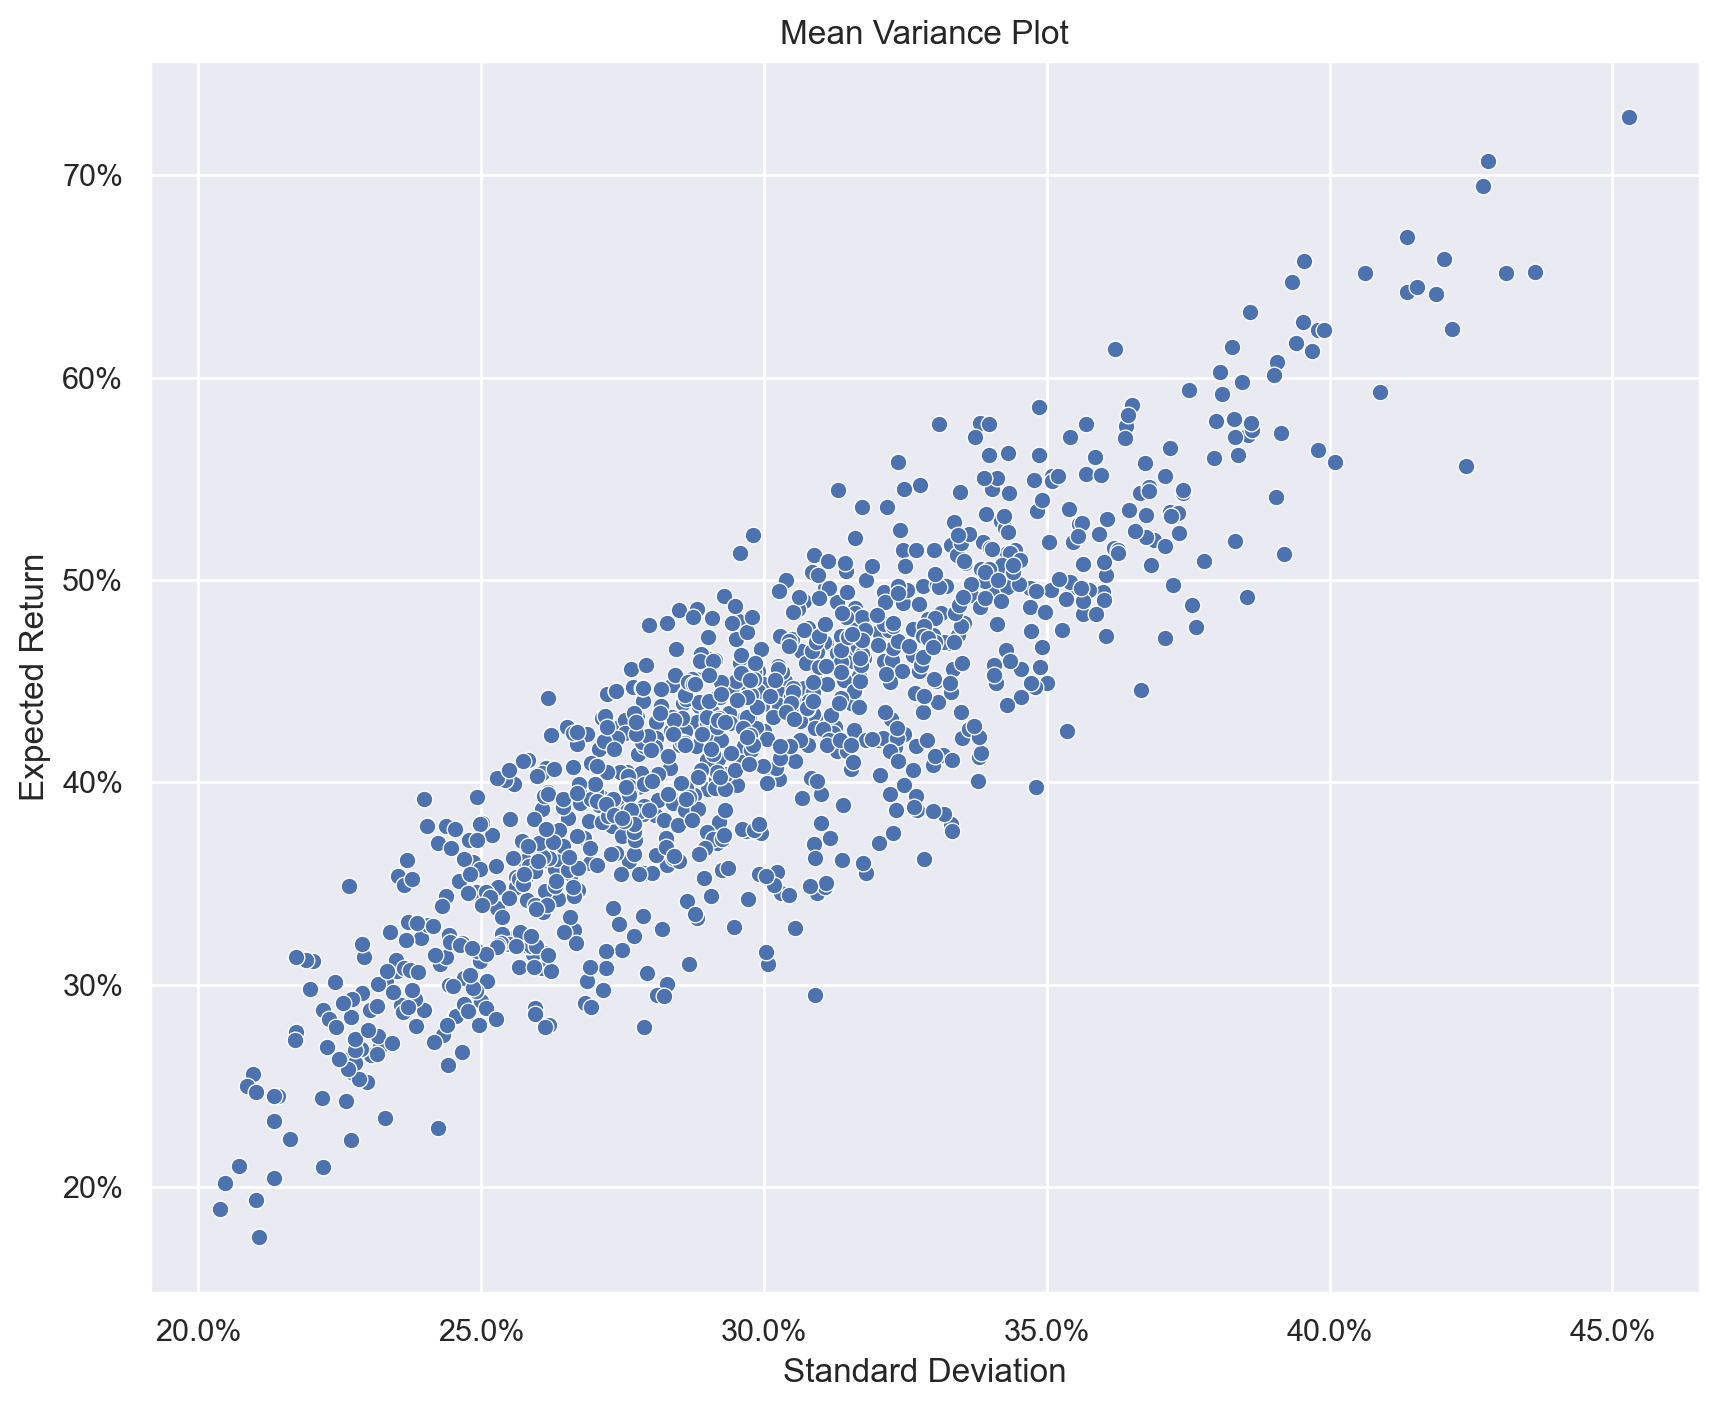

In [89]:
mean_var_plot = sns.scatterplot(
    data=randomPortfolios,
    x="Standard Deviation",
    y="Expected Return",
).set(title="Mean Variance Plot")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.show()


 ##### Minimum Volatility

In [90]:
# idxmin() gives us the min value per column specified
min_vol_port = randomPortfolios.iloc[randomPortfolios["Standard Deviation"].idxmin()]
min_vol_port = min_vol_port.to_frame().T
min_vol_port.index = ["Random Minimum Variance Portfolio"]


In [91]:
with pd.option_context("display.float_format", PERCENT.format):
    display(min_vol_port.T)


Random Minimum Variance Portfolio
Expected Return                               18.893%
Standard Deviation                            20.391%
COPX                                          22.274%
CURE                                           1.003%
TAN                                           15.514%
TECL                                           1.843%
UNL                                           59.367%

 Interesting, this minimum random portfolio beat our minimum variance portfolio
 in terms of expected return but not in minimizing volatility. Yet, it doesn't
 incur in short-selling.

In [92]:
with pd.option_context("display.float_format", PERCENT.format):
    display(annual_mean_var, w_star)


Index  Expected Return  Standard Deviation
0                               COPX          17.123%             34.553%
1                               CURE          46.883%             46.464%
2                                TAN          41.105%             38.750%
3                               TECL          96.264%             58.195%
4                                UNL          10.878%             28.062%
5         Equally Weighted Portfolio          39.735%             29.132%
6  Global Minimum Variance Portfolio          17.193%             19.939%

w*
COPX 21.697%
CURE 11.153%
TAN  20.280%
TECL -6.415%
UNL  53.285%

  ##### Maximum Sharpe Ratio

In [93]:
annual_RiskFree = riskFree * 12
optimal_risky_port = randomPortfolios.iloc[
    (
        (randomPortfolios["Expected Return"] - annual_RiskFree)
        / randomPortfolios["Standard Deviation"]
    ).idxmax()
]

optimal_risky_port = optimal_risky_port.to_frame().T
optimal_risky_port.index = ["Random Maximum Sharpe Ratio Portfolio"]


In [94]:
with pd.option_context("display.float_format", PERCENT.format):
    display(optimal_risky_port)


Expected Return  Standard Deviation  \
Random Maximum Sharpe Ratio Portfolio          52.202%             29.803%   

                                        COPX   CURE     TAN    TECL     UNL  
Random Maximum Sharpe Ratio Portfolio 0.883% 2.530% 11.260% 43.280% 42.048%

In [95]:
annual_mean_var = pd.concat(
    [
        annual_mean_var.set_index("Index"),
        min_vol_port[["Expected Return", "Standard Deviation"]],
        optimal_risky_port[["Expected Return", "Standard Deviation"]],
    ]
).reset_index()


In [96]:
annual_mean_var.columns = ["Index", "Expected Return", "Standard Deviation"]


In [97]:
with pd.option_context("display.float_format", PERCENT.format):
    display(annual_mean_var)


Index  Expected Return  Standard Deviation
0                                   COPX          17.123%             34.553%
1                                   CURE          46.883%             46.464%
2                                    TAN          41.105%             38.750%
3                                   TECL          96.264%             58.195%
4                                    UNL          10.878%             28.062%
5             Equally Weighted Portfolio          39.735%             29.132%
6      Global Minimum Variance Portfolio          17.193%             19.939%
7      Random Minimum Variance Portfolio          18.893%             20.391%
8  Random Maximum Sharpe Ratio Portfolio          52.202%             29.803%

In [98]:
randomPortfolios


Expected Return  Standard Deviation      COPX      CURE       TAN  \
0           0.504449            0.314567  0.017585  0.261796  0.215569   
1           0.324839            0.256578  0.300058  0.230187  0.068800   
2           0.456896            0.348784  0.188137  0.421262  0.196718   
3           0.345143            0.309361  0.329891  0.413990  0.103221   
4           0.329976            0.274479  0.295292  0.302140  0.160193   
..               ...                 ...       ...       ...       ...   
995         0.338603            0.243041  0.233883  0.045673  0.264094   
996         0.314649            0.261900  0.118819  0.436836  0.113893   
997         0.473430            0.315626  0.238265  0.080176  0.222314   
998         0.418553            0.315483  0.246848  0.260980  0.271509   
999         0.297175            0.237788  0.088913  0.357332  0.122600   

         TECL       UNL  
0    0.275398  0.229651  
1    0.109673  0.291282  
2    0.146663  0.047220  
3    0.041580  0.111318  
4    0.053343  0.189032  
..        ...       ...  
995  0.139302  0.317047  
996  0.007892  0.322560  
997  0.297127  0.162118  
998  0.138574  0.082090  
999  0.020057  0.411098  

[1000 rows x 7 columns]

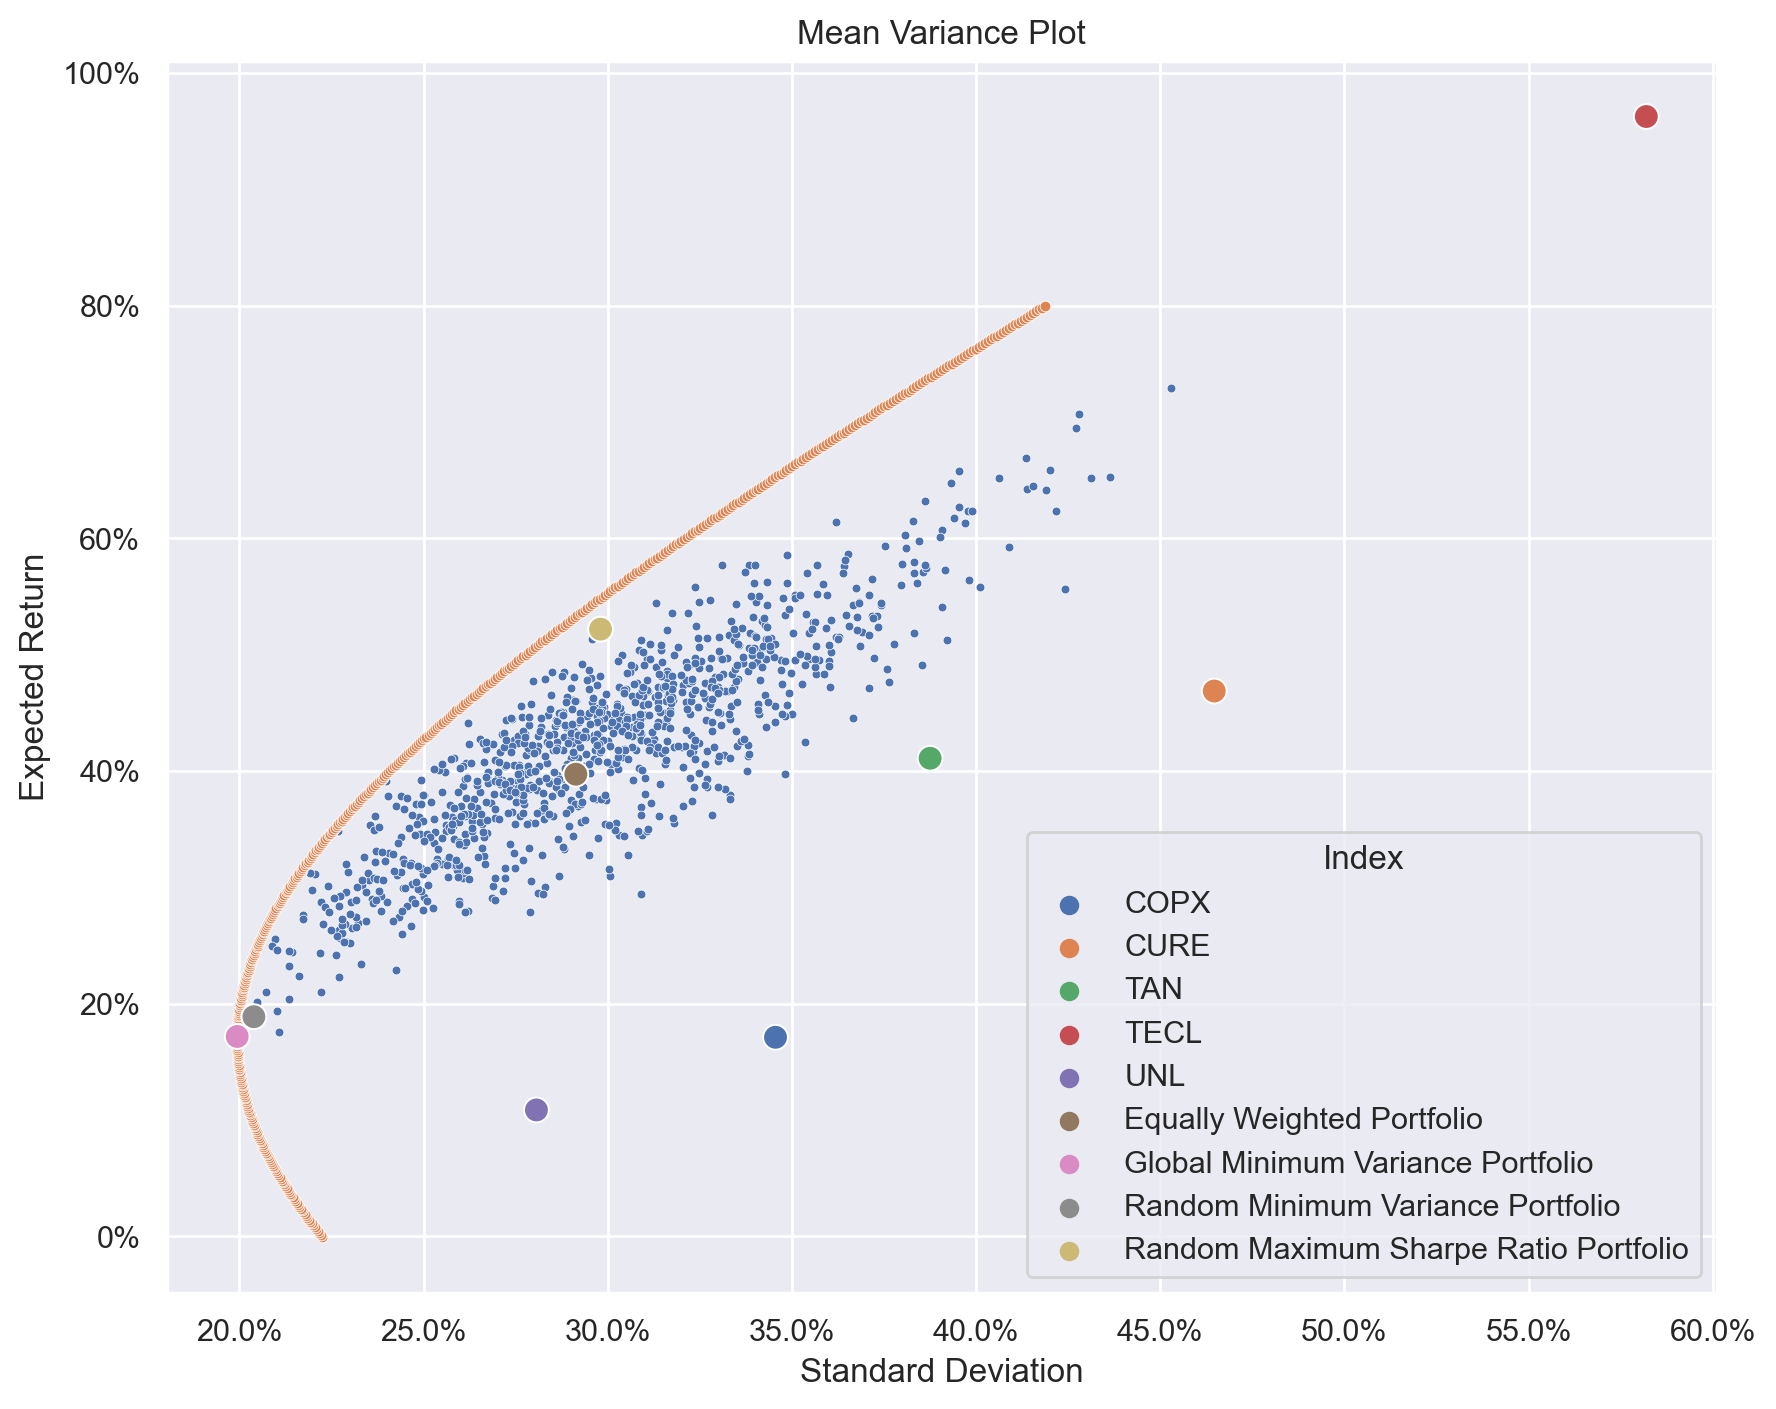

In [99]:
mean_var_plot = sns.scatterplot(
    data=randomPortfolios, x="Standard Deviation", y="Expected Return", s=10
).set(title="Mean Variance Plot")


sns.scatterplot(data=frontier_df(0.8), x="SD(P)", y="E(Rp)", s=15).set(
    title="Mean Variance Plot"
)

results_plot = sns.scatterplot(
    data=annual_mean_var, x="Standard Deviation", y="Expected Return", hue="Index", s=80
).set(title="Mean Variance Plot")

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.show()


 After looking at this graph we can see that while the randomly generated
 Maximum Sharpe Ratio Portfolio lies outside the frontier, it is likely (at
 least I think so) that this is due to the lack of constraint of short-seling
 in the mean variance frontier matrix formulation

 ## Part Five: Performance

 Rank the performance of the five funds and the five-fund portfolio according
 to the following criteria:

 - The Sharpe Measure
 - The Treynor Measure
 - Geometric Mean Return

 ### Sharpe Measure

 > Note: The textbook claims the following:


 ![image](https://user-images.githubusercontent.com/13838845/153757379-29865a3b-f999-44b5-b9bd-4e6b648a2e2f.png)

 $$
 \text{Sharpe Measure} = \frac{\overline{R} - R_f}{\sigma}
 $$

In [100]:
with pd.option_context("display.float_format", PERCENT.format):
    display(annual_mean_var.set_index("Index"))


Expected Return  Standard Deviation
Index                                                                     
COPX                                           17.123%             34.553%
CURE                                           46.883%             46.464%
TAN                                            41.105%             38.750%
TECL                                           96.264%             58.195%
UNL                                            10.878%             28.062%
Equally Weighted Portfolio                     39.735%             29.132%
Global Minimum Variance Portfolio              17.193%             19.939%
Random Minimum Variance Portfolio              18.893%             20.391%
Random Maximum Sharpe Ratio Portfolio          52.202%             29.803%

In [101]:
annual_mean_var["Sharpe Ratio"] = (
    annual_mean_var["Expected Return"] - annual_RiskFree
) / annual_mean_var["Standard Deviation"]


In [102]:
randomPortfolios["Sharpe Ratio"] = (
    randomPortfolios["Expected Return"] - riskFree
) / randomPortfolios["Standard Deviation"]


In [103]:
randomPortfolios


Expected Return  Standard Deviation      COPX      CURE       TAN  \
0           0.504449            0.314567  0.017585  0.261796  0.215569   
1           0.324839            0.256578  0.300058  0.230187  0.068800   
2           0.456896            0.348784  0.188137  0.421262  0.196718   
3           0.345143            0.309361  0.329891  0.413990  0.103221   
4           0.329976            0.274479  0.295292  0.302140  0.160193   
..               ...                 ...       ...       ...       ...   
995         0.338603            0.243041  0.233883  0.045673  0.264094   
996         0.314649            0.261900  0.118819  0.436836  0.113893   
997         0.473430            0.315626  0.238265  0.080176  0.222314   
998         0.418553            0.315483  0.246848  0.260980  0.271509   
999         0.297175            0.237788  0.088913  0.357332  0.122600   

         TECL       UNL  Sharpe Ratio  
0    0.275398  0.229651      1.600764  
1    0.109673  0.291282      1.262531  
2    0.146663  0.047220      1.307384  
3    0.041580  0.111318      1.112752  
4    0.053343  0.189032      1.198909  
..        ...       ...           ...  
995  0.139302  0.317047      1.389487  
996  0.007892  0.322560      1.197967  
997  0.297127  0.162118      1.497115  
998  0.138574  0.082090      1.323848  
999  0.020057  0.411098      1.245957  

[1000 rows x 8 columns]

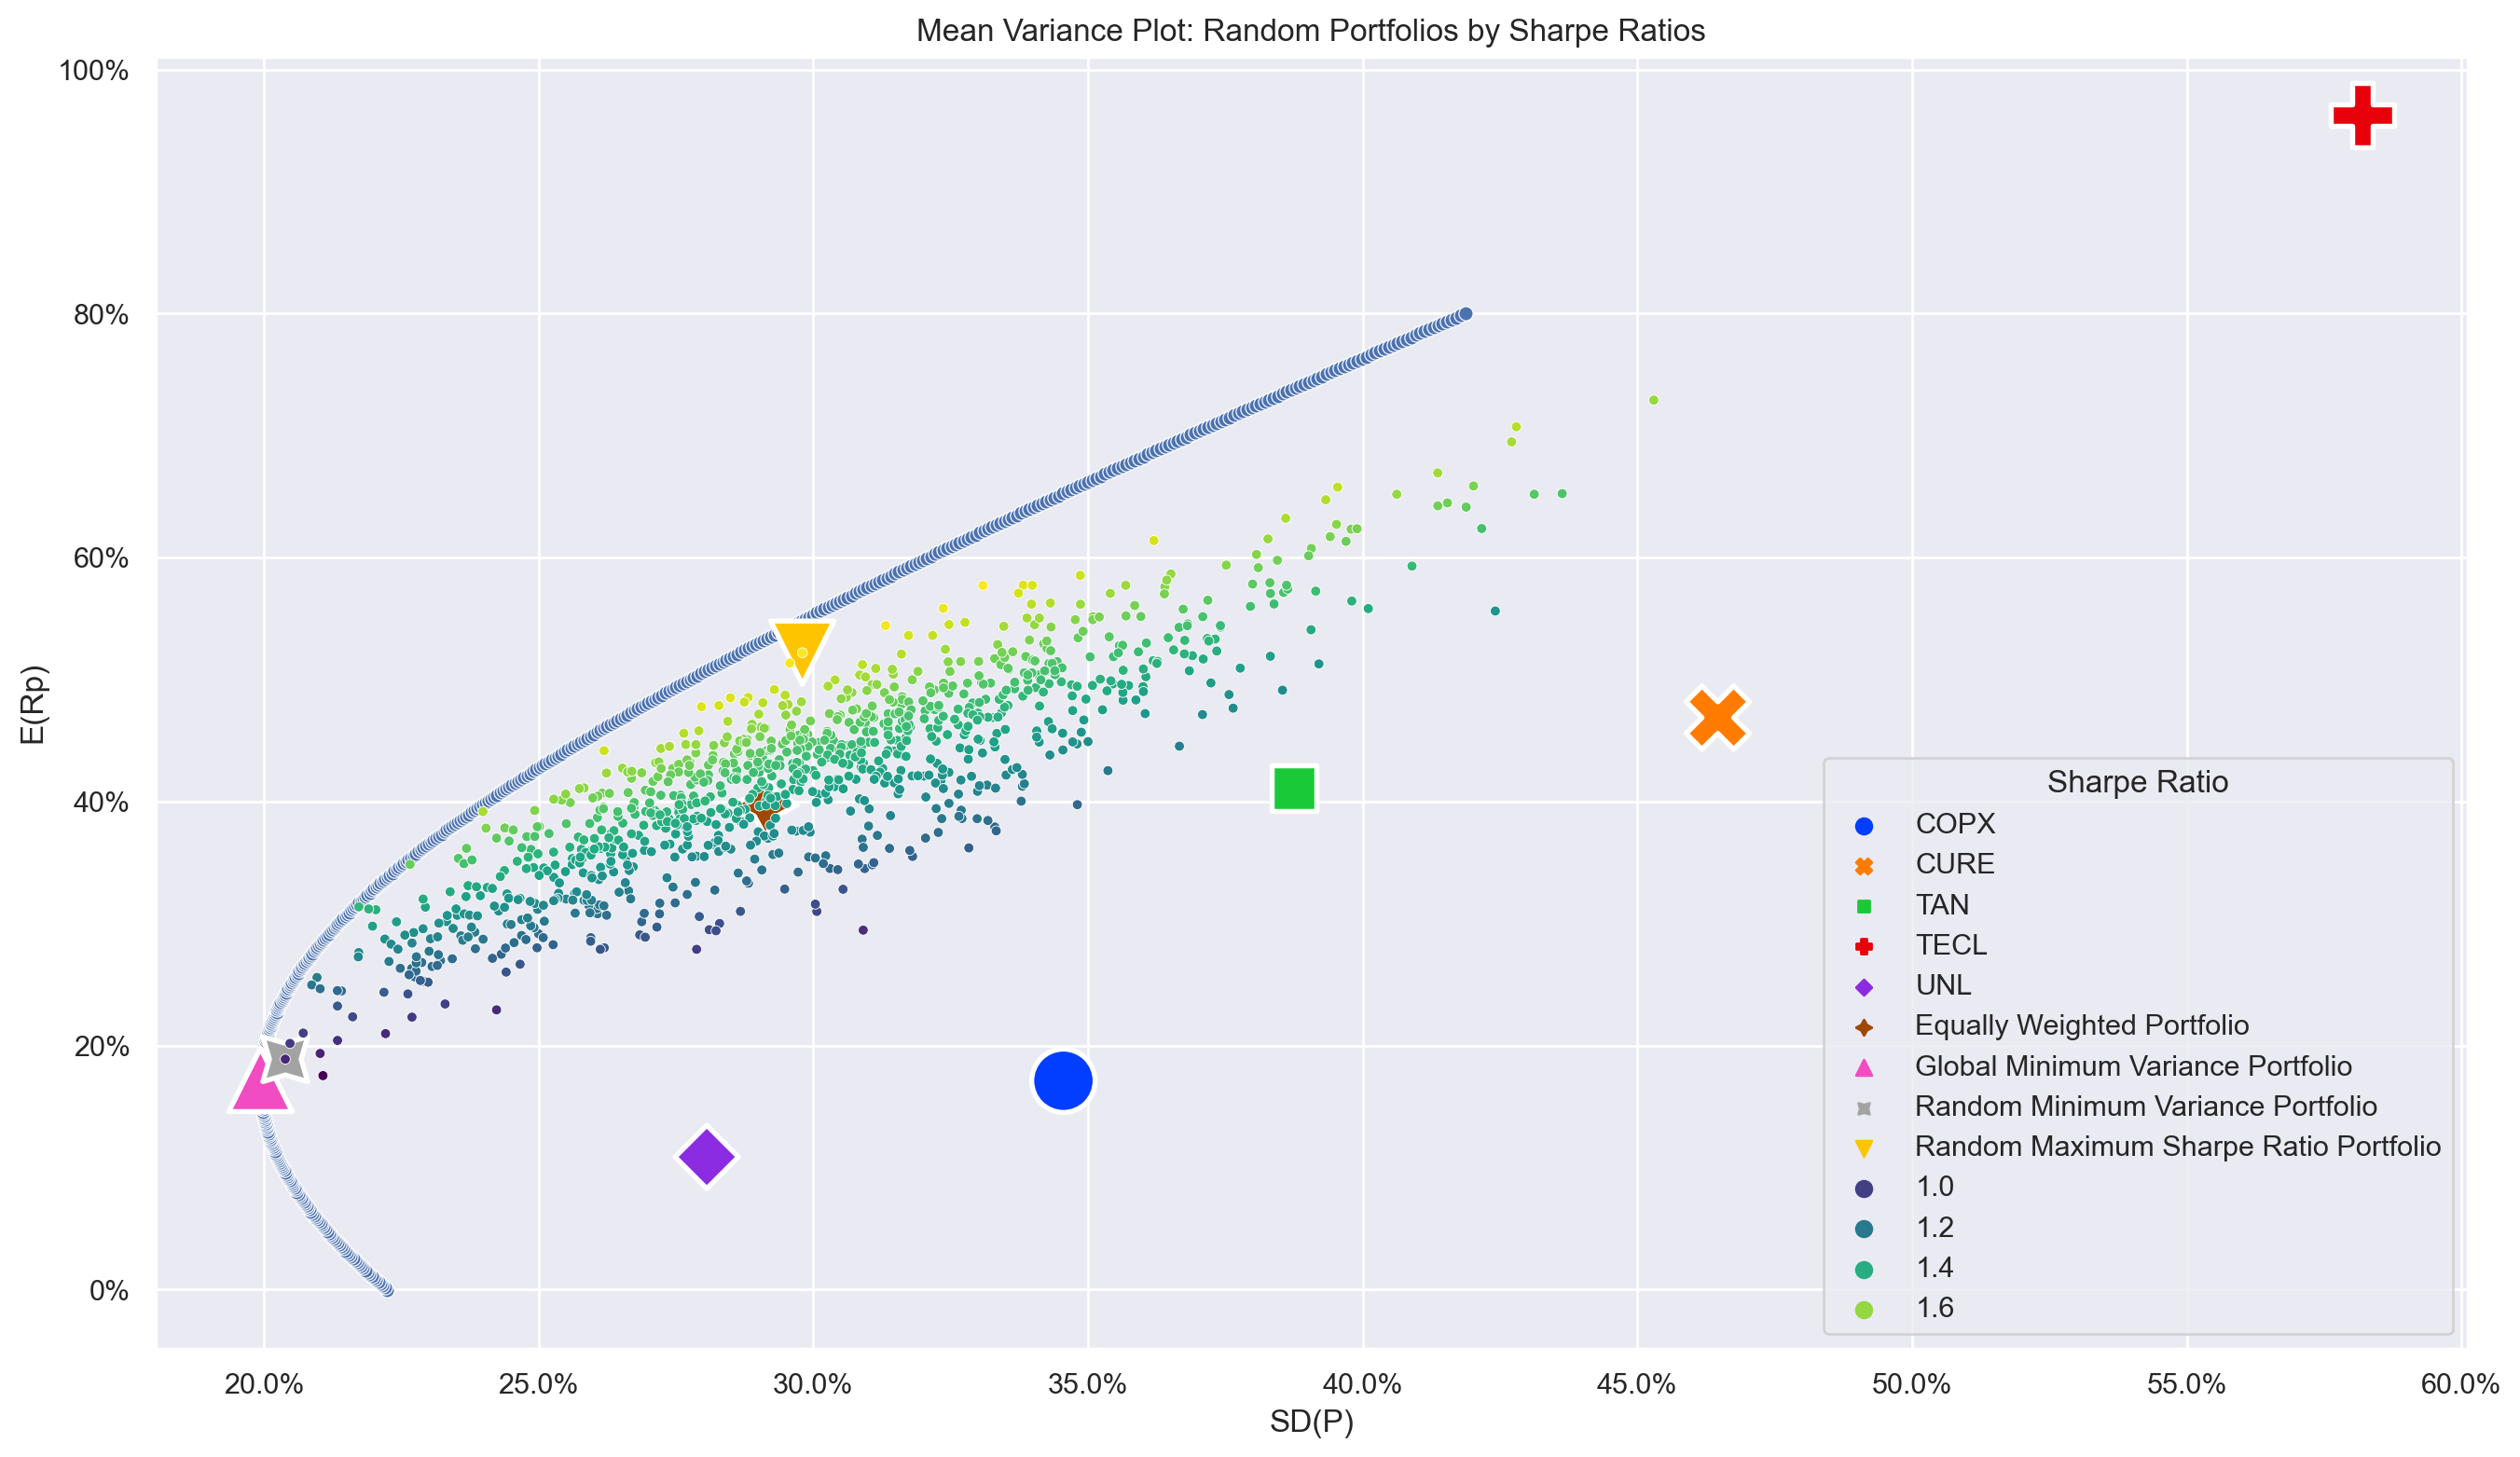

In [104]:
sns.set(rc={"figure.figsize": (16, 9)})

sns.scatterplot(data=frontier_df(0.8), x="SD(P)", y="E(Rp)", s=30)

results_plot = sns.scatterplot(
    data=annual_mean_var,
    x="Standard Deviation",
    y="Expected Return",
    style="Index",
    hue="Index",
    s=600,
    marker="*",
    palette="bright",
)

mean_var_plot = sns.scatterplot(
    data=randomPortfolios,
    x="Standard Deviation",
    y="Expected Return",
    palette="viridis",
    hue="Sharpe Ratio",
    s=15,
).set(title="Mean Variance Plot: Random Portfolios by Sharpe Ratios")

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.show()


 ### Treynor Measure

 $$
 \text{Treynor Measure} = \frac{\overline{R} - R_f}{\beta}
 $$

In [105]:
all_betas = list(list(betas.mean()))


In [106]:
all_betas.append(
    np.array([1 / n_size] * n_size).dot(list(betas.mean()))
)  # equally weighted portfolio


In [107]:
all_betas.append(w_star.T.dot(betas.mean())[0])


In [108]:
all_betas.append(min_vol_port[funds].dot(list(betas.mean()))[0])
all_betas.append(optimal_risky_port[funds].dot(list(betas.mean()))[0])


In [109]:
annual_mean_var["Beta"] = all_betas


In [110]:
annual_mean_var["Treynor Ratio"] = annual_mean_var["Sharpe Ratio"] = (
    annual_mean_var["Expected Return"] - annual_RiskFree
) / annual_mean_var["Beta"]


In [111]:
annual_mean_var.set_index("Index").style.format(
    {"Expected Return": PERCENT, "Standard Deviation": PERCENT}
)


In [112]:
all_geo = list(annual_geo_from_monthly(returns))
annual_geo = list(annual_geo_from_monthly(returns))


In [113]:
all_geo.append(
    np.array([1 / n_size] * n_size).dot(annual_geo)
)  # equally weighted portfolio


In [114]:
all_geo.append(w_star.T.dot(annual_geo)[0])


In [115]:
all_geo.append(min_vol_port[funds].dot(annual_geo)[0])
all_geo.append(optimal_risky_port[funds].dot(annual_geo)[0])


In [116]:
annual_mean_var["Geometric Mean"] = all_geo


 ### Rankings

 #### Sharpe Measure: Rankings

In [117]:
annual_mean_var.set_index("Index").sort_values(
    by="Sharpe Ratio", ascending=False
).style.format(
    {
        "Expected Return": PERCENT,
        "Standard Deviation": PERCENT,
        "Geometric Mean": PERCENT,
    }
)


<AxesSubplot:title={'center':'Sharpe Ratios'}, ylabel='Index'>

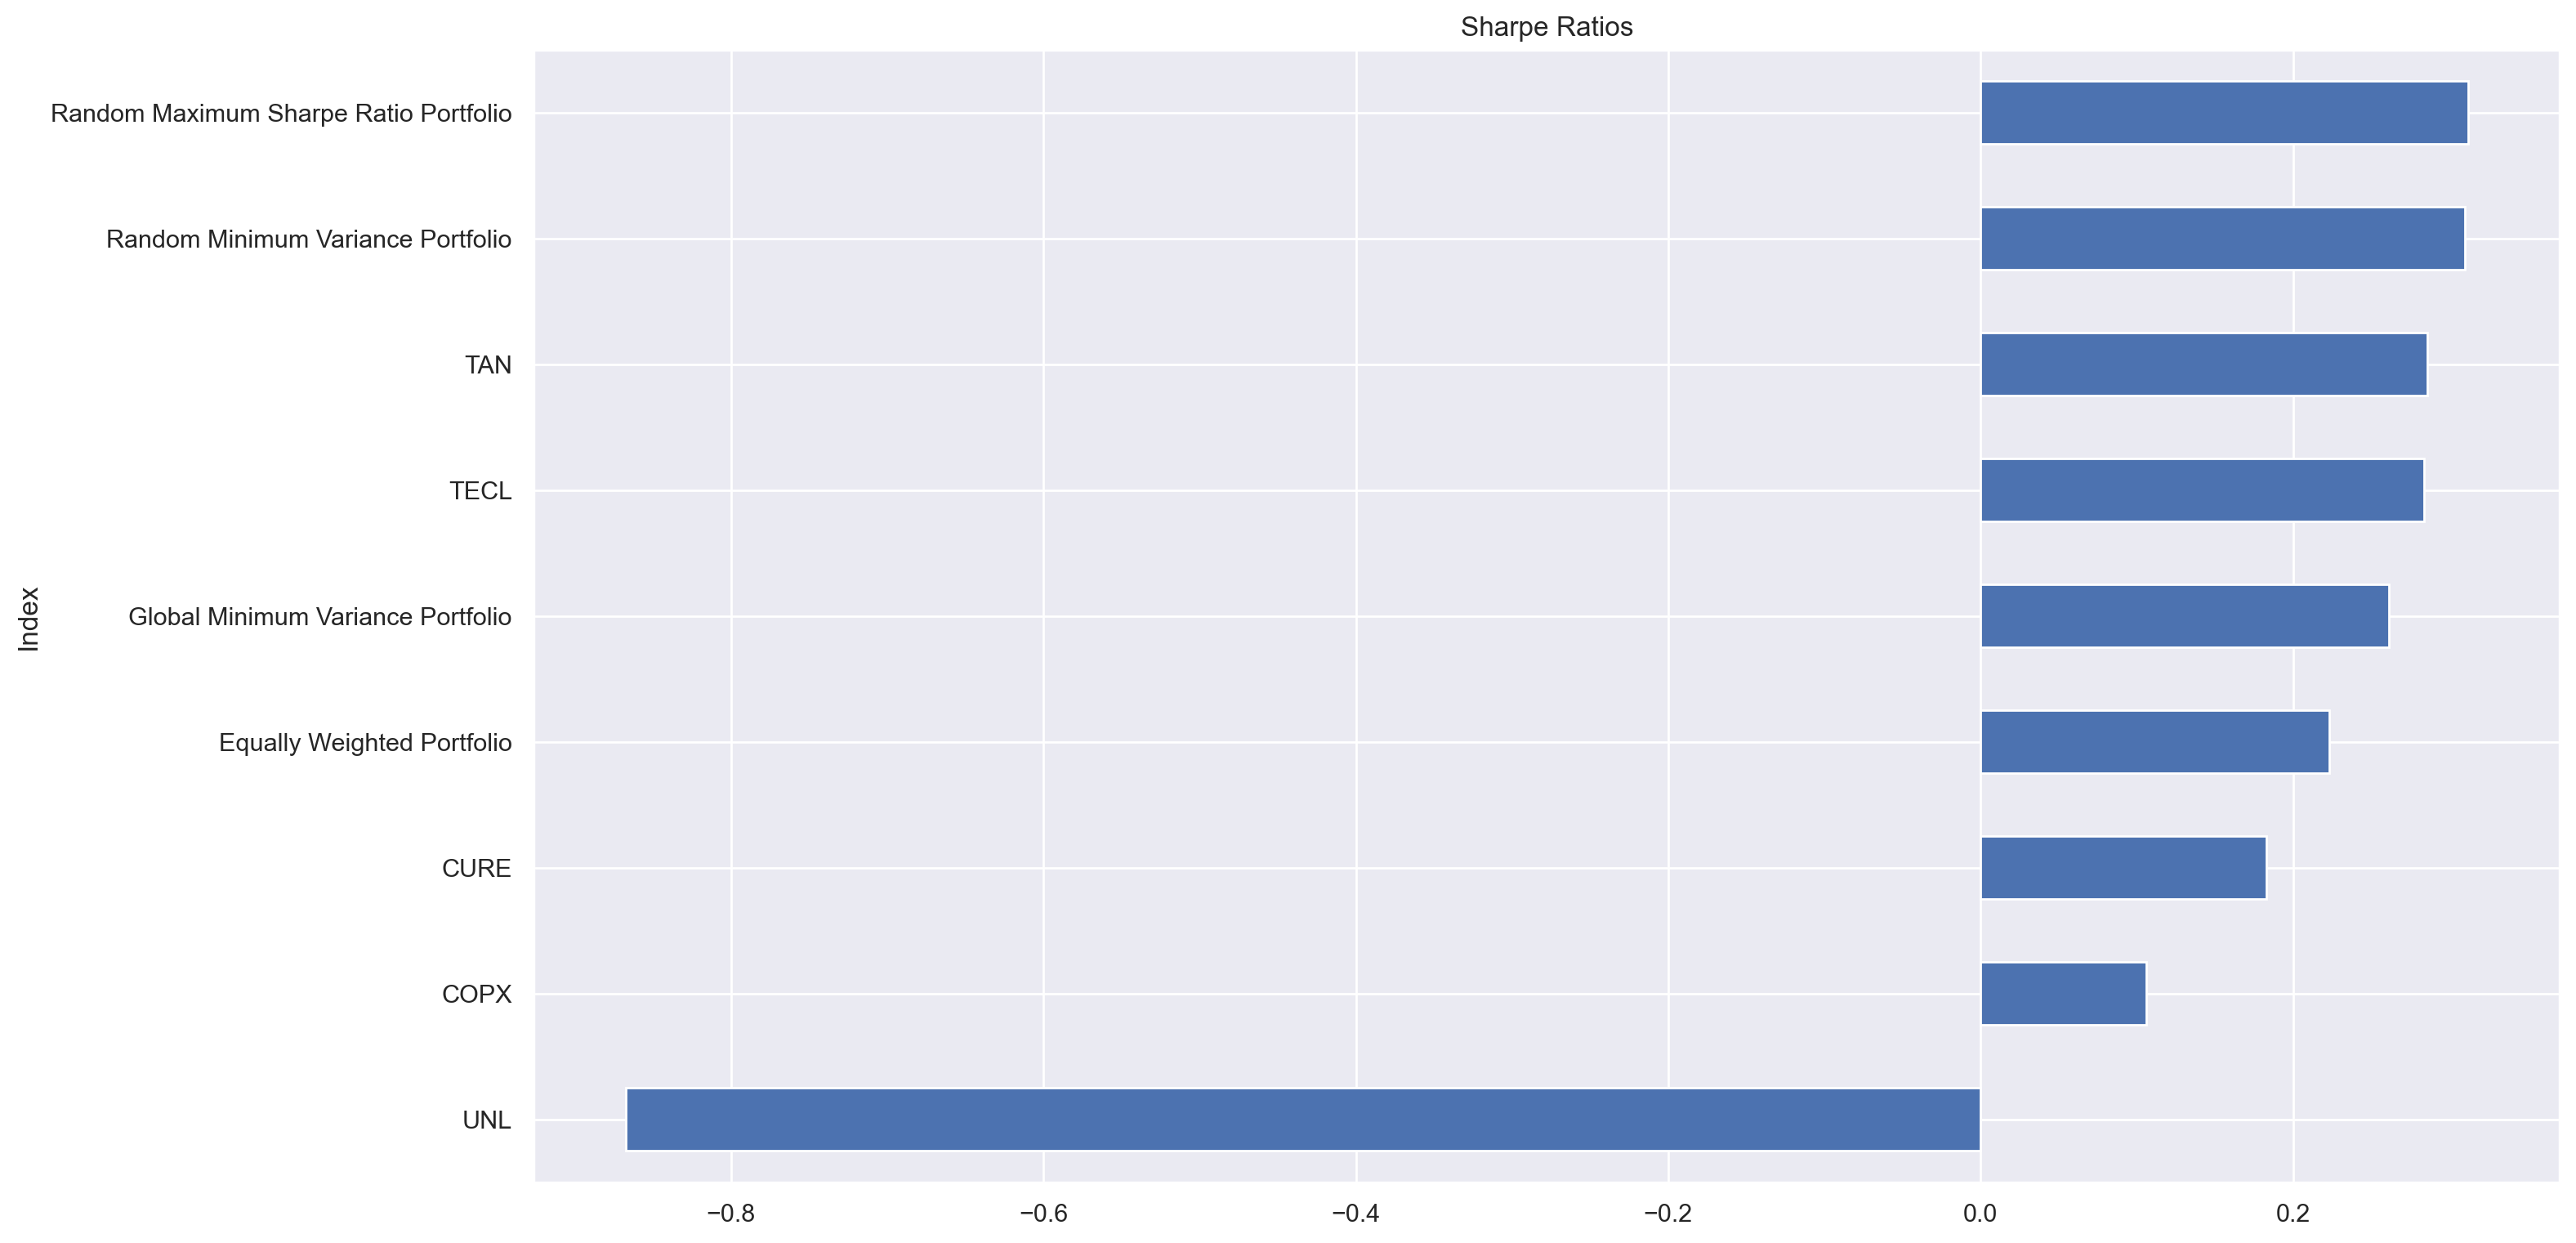

In [118]:
annual_mean_var.set_index("Index")["Sharpe Ratio"].sort_values().plot(
    kind="barh", title="Sharpe Ratios"
)
# plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))


 #### Treynor Measure: Rankings

In [119]:
annual_mean_var.set_index("Index").sort_values(
    by="Treynor Ratio", ascending=False
).style.format(
    {
        "Expected Return": PERCENT,
        "Standard Deviation": PERCENT,
        "Geometric Mean": PERCENT,
    }
)


<AxesSubplot:title={'center':'Treynor Ratio'}, ylabel='Index'>

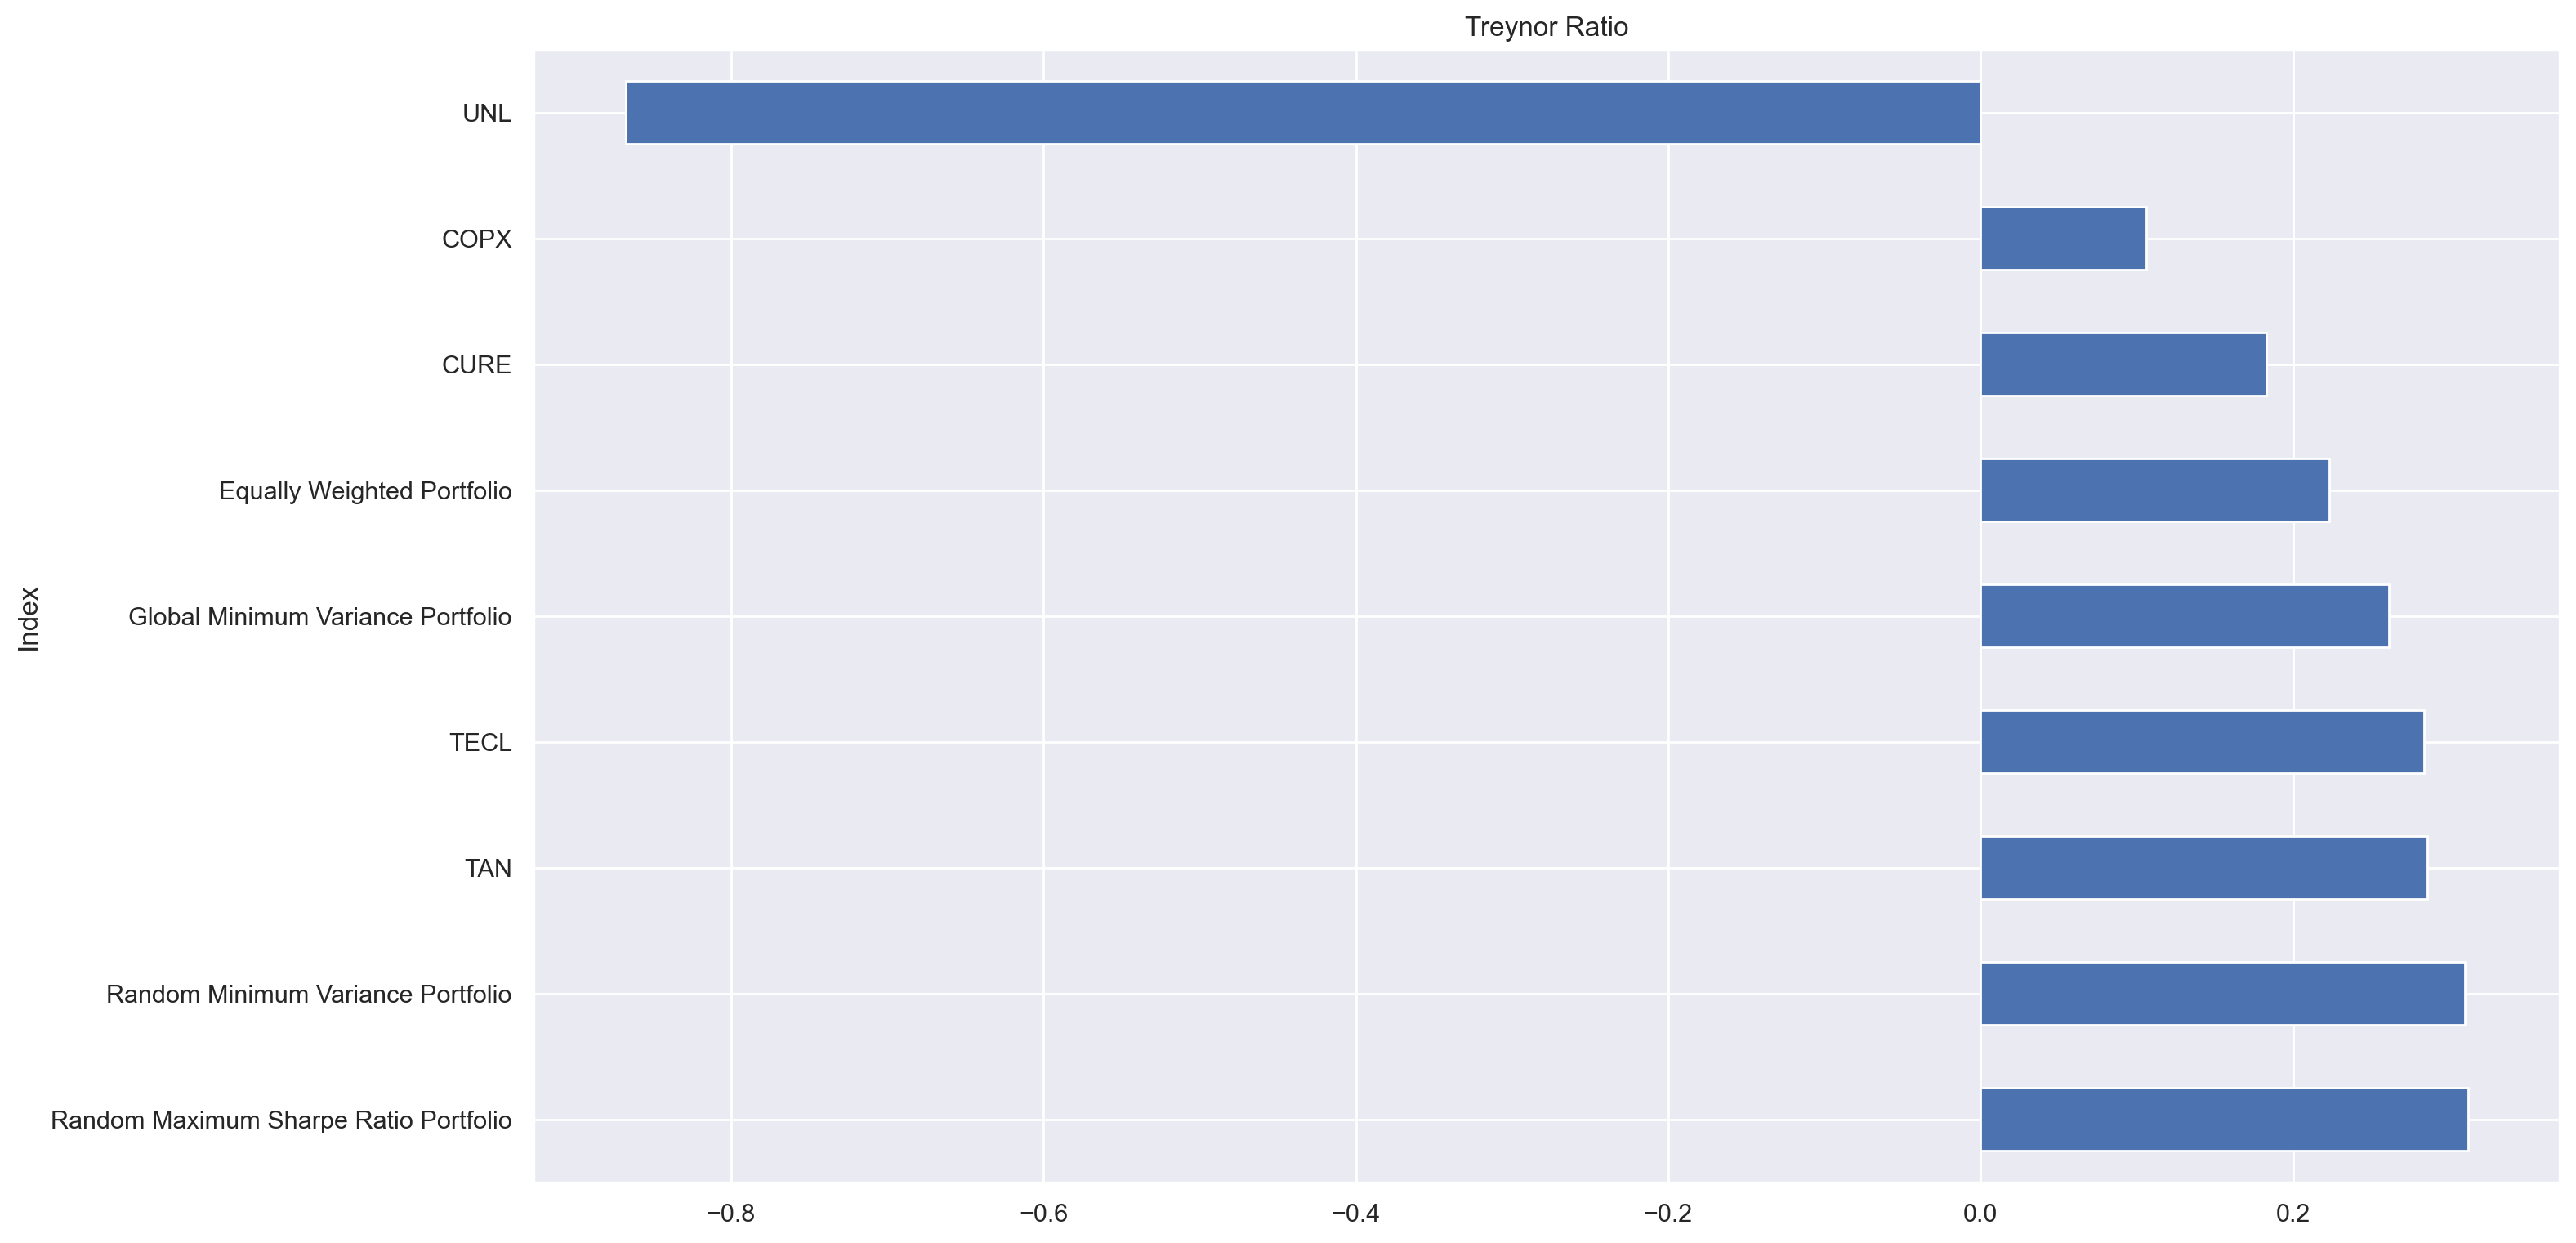

In [120]:
annual_mean_var.set_index("Index")["Treynor Ratio"].sort_values(ascending=False).plot(
    kind="barh", title="Treynor Ratio"
)
# plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))


 #### Geometric Mean: Rankings

In [121]:
annual_mean_var.set_index("Index").sort_values(
    by="Geometric Mean", ascending=False
).style.format(
    {
        "Expected Return": PERCENT,
        "Standard Deviation": PERCENT,
        "Geometric Mean": PERCENT,
    }
)


<AxesSubplot:title={'center':'Geometric Mean'}, ylabel='Index'>

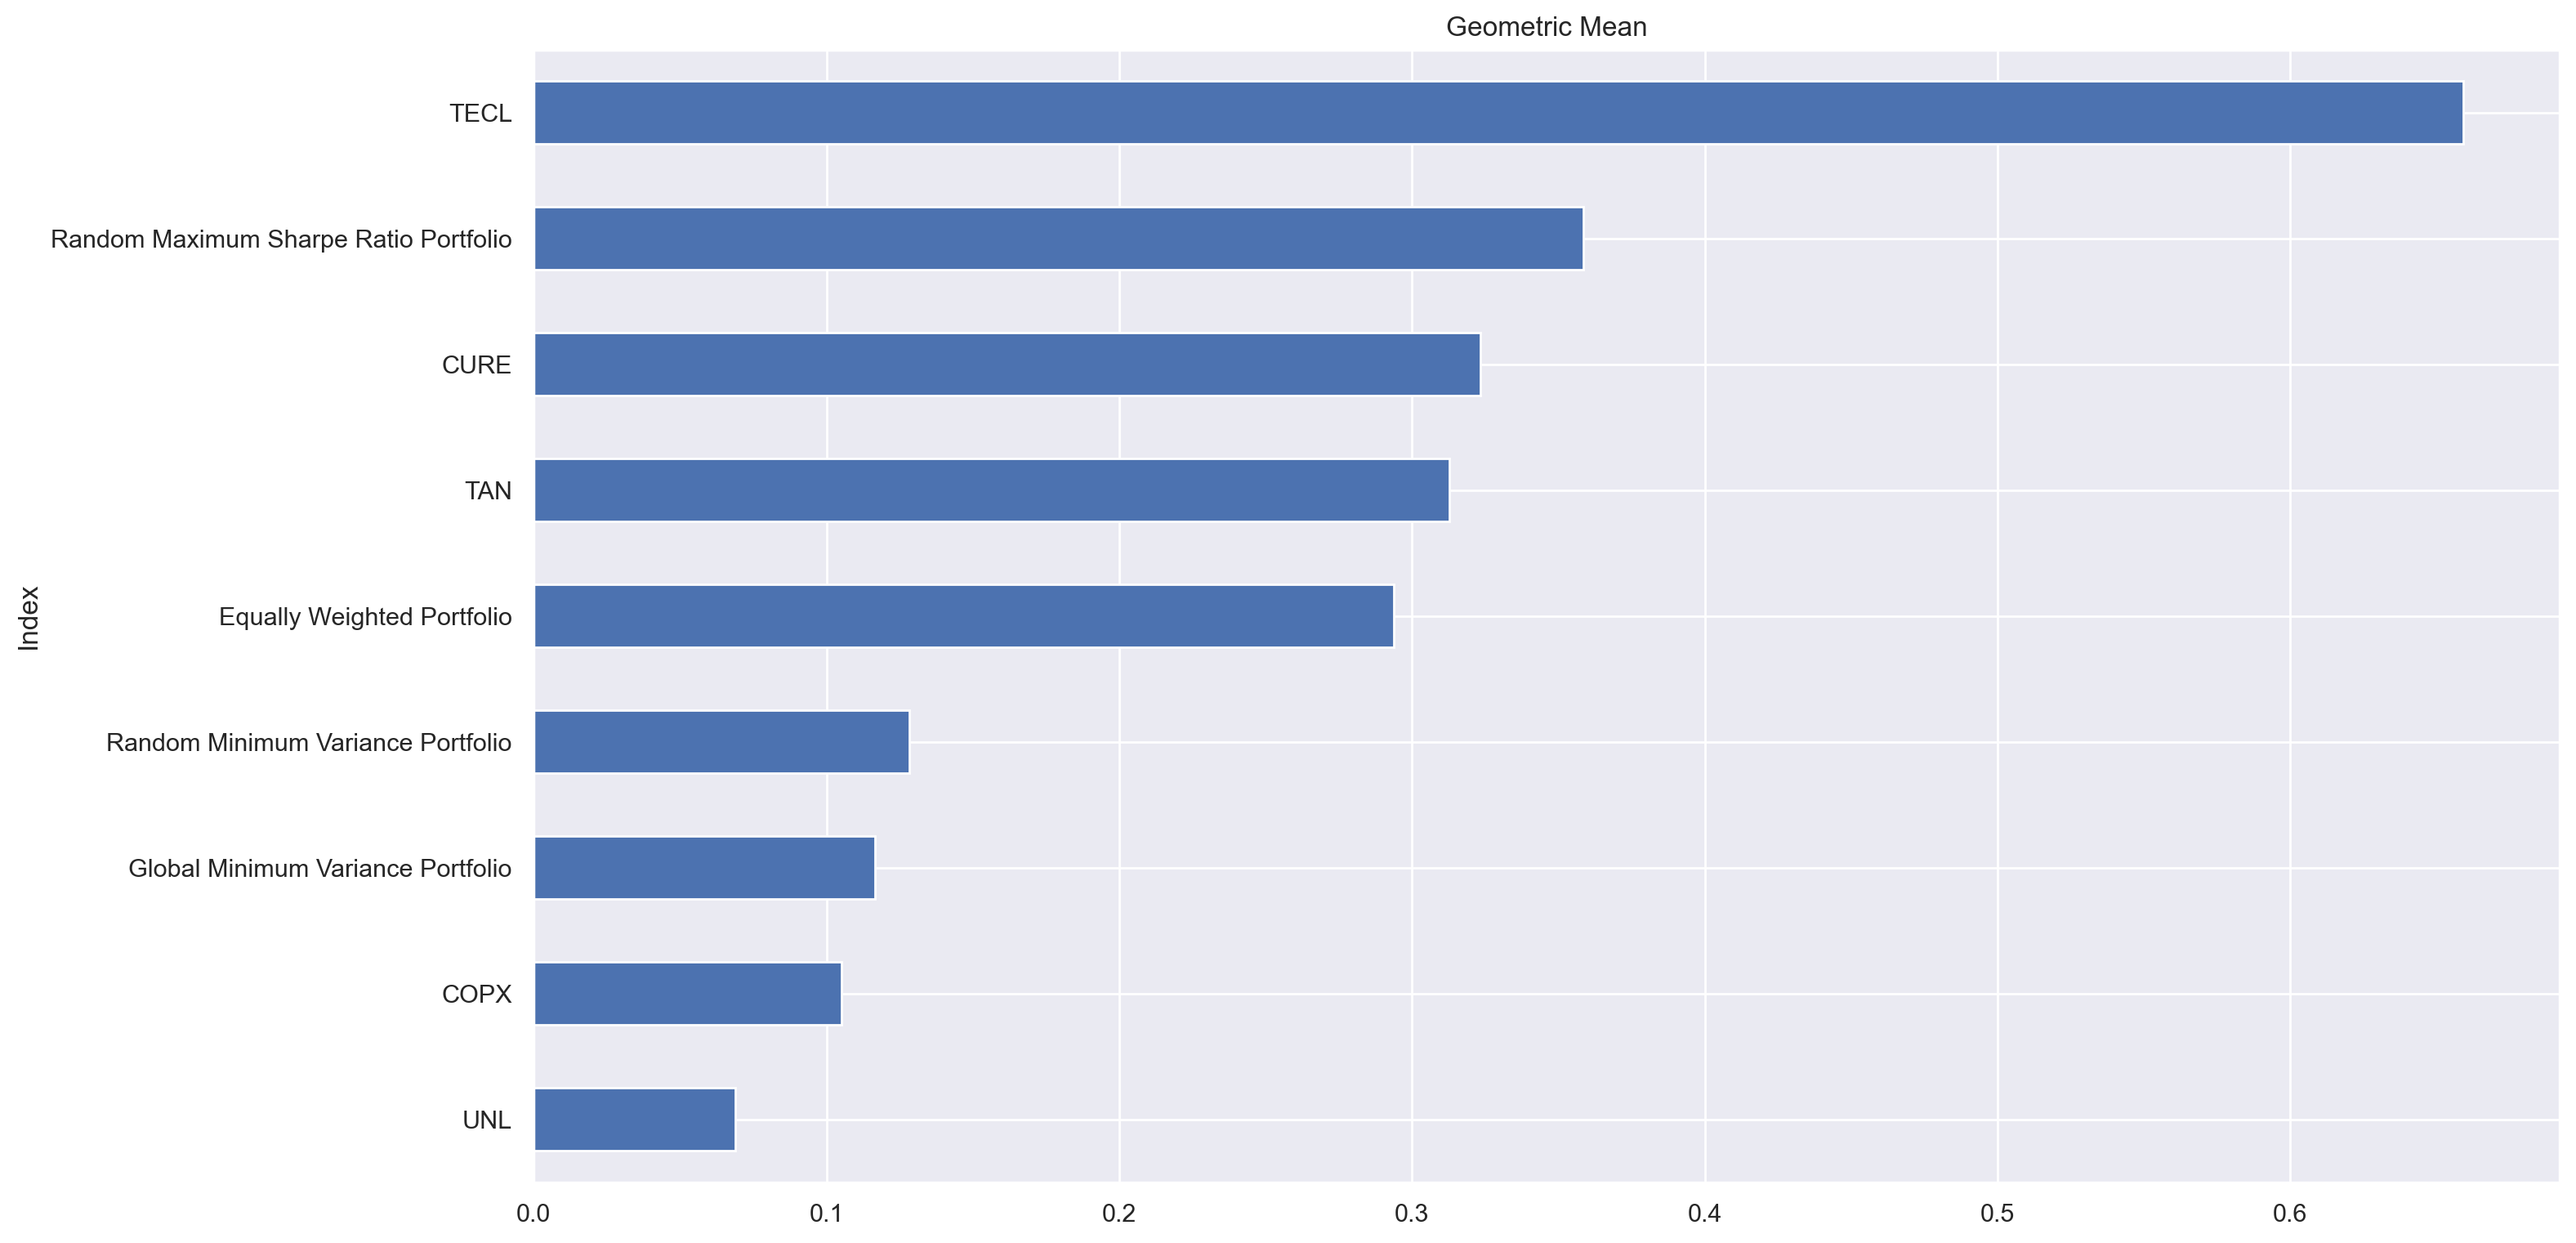

In [122]:
annual_mean_var.set_index("Index")["Geometric Mean"].sort_values().plot(
    kind="barh", title="Geometric Mean"
)
# plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
